## 0. 라이브러리 및 데이터 준비

In [1]:
# 라이브러리 호출
import os
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 경고 무시
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
# 데이터 로드
# path = os.getenv('HOME')+'aiffel/datacon/tracin.csv'
# # crime_path = join(data_dir, 'train.csv')
# raw = pd.read_csv(path)
path = os.getenv('HOME') + '/aiffel/datacon/train.csv'
raw = pd.read_csv(path)
#### 클라우드에서 돌릴거면 위에 주석 해제하시면 됩니다
# raw = pd.read_csv('/Users/iseoyeong/Desktop/datacon/train.csv')

In [4]:
# 복사해서 사용
data = raw.copy()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB


## 1. 전처리
###### 1) 시계열 데이터 추출

In [6]:
# 컬럼 생성
data['date_year'] = data['Dates'].apply(lambda x: x[:4])
data['date_month'] = data['Dates'].apply(lambda x: x[5:7])
data['date_hour'] = data['Dates'].apply(lambda x: x[10:13])

###### 2) 기타 범죄

In [7]:
len(data[data['Category']=='OTHER OFFENSES'])

126182

제외하기로 결정함

In [8]:
# 행 삭제
indices = data[data['Category']=='OTHER OFFENSES'].index
data = data.drop(indices)

###### 3) 카테고리 재분류

In [9]:
def categorize(row, col='Category'):
    if (row[col]=='LARCENY/THEFT')|(row[col]=='VEHICLE THEFT')|(row[col]=='BURGLARY')|(row[col]=='STOLEN PROPERTY')|(row[col]=='STOLEN PROPERTY')|(row[col]=='EXTORTION'):
        return 'Property Crimes'
    elif (row[col]=='ASSAULT')|(row[col]=='KIDNAPPING')|(row[col]=='SEX OFFENSES FORCIBLE')|(row[col]=='ROBBERY')|(row[col]=='HOMICIDE')|(row[col]=='FAMILY OFFENSES')|(row[col]=='TRESPASS'):
        return 'Personal Crimes'
    elif (row[col]=='DRUNKENNESS')|(row[col]=='DRIVING UNDER THE INFLUENCE')|(row[col]=='LIQUOR LAWS'):
        return 'Alcohol-Related Crimes'
    elif (row[col]=='DISORDERLY CONDUCT')|(row[col]=='LOITERING'):
        return 'Disorderly Conduct'
    elif (row[col]=='FORGERY/COUNTERFEITING')|(row[col]=='FRAUD'):
        return 'Fraud and Forgery'
    elif row[col]=='WEAPON LAWS':
        return 'Weapon-Related Crimes'
    elif row[col]=='DRUG/NARCOTIC':
        return 'Drug-Related Crimes'
    elif (row[col]=='BAD CHECKS')|(row[col]=='EMBEZZLEMENT')|(row[col]=='BRIBERY'):
        return 'Financial Crimes'
    elif row[col]=='TREA':
        return 'Terrorist Offender'
    else:
        return 'Other Crimes'

In [10]:
data['type'] = data.apply(categorize, axis=1)

In [11]:
# 생성된 컬럼 값 확인
data['type'].value_counts()

Property Crimes           270232
Other Crimes              261536
Personal Crimes           114422
Drug-Related Crimes        53971
Fraud and Forgery          27288
Weapon-Related Crimes       8555
Alcohol-Related Crimes      8451
Disorderly Conduct          5545
Financial Crimes            1861
Terrorist Offender             6
Name: type, dtype: int64

###### 컬럼 이름 변경

In [12]:
# 위도, 경도
data.rename(columns={'Y':'lat', 'X':'lng'}, inplace=True)

In [13]:
# 컬럼 정리
columns = ['Dates', 'date_year', 'date_month', 'date_hour', 'DayOfWeek', 'Category', 'type', 'Descript', 'PdDistrict', 'Resolution', 'Address', 'lat', 'lng']
data = data[columns]

In [14]:
data.head()

,Dates,date_year,date_month,date_hour,DayOfWeek,Category,type,Descript,PdDistrict,Resolution,Address,lat,lng
0,2015-05-13 23:53:00,2015,05,23,Wednesday,WARRANTS,Other Crimes,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,37.774599,-122.425892
3,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,37.800873,-122.426995
4,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,37.771541,-122.438738
5,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM UNLOCKED AUTO,INGLESIDE,NONE,0 Block of TEDDY AV,37.713431,-122.403252
6,2015-05-13 23:30:00,2015,05,23,Wednesday,VEHICLE THEFT,Property Crimes,STOLEN AUTOMOBILE,INGLESIDE,NONE,AVALON AV / PERU AV,37.725138,-122.423327


## 2. EDA

###### 1) 사건 해결 여부

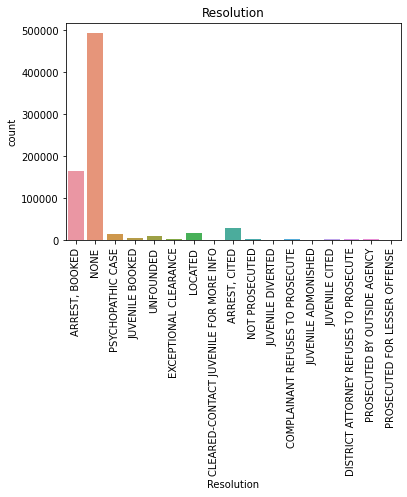

In [15]:
sns.countplot(data=data, x='Resolution')
plt.xticks(rotation=90)
plt.title('Resolution')
plt.show()

미해결된 사건(NONE)이 압도적으로 많으므로 이에 대해 집중적으로 분석할 필요가 있음

###### 2) 미해결 사건의 범죄 유형

In [16]:
# 미해결 사건을 분리해서 다루기 위해 따로 변수에 저장
unsolved_crime_data = data[data['Resolution']=='NONE']

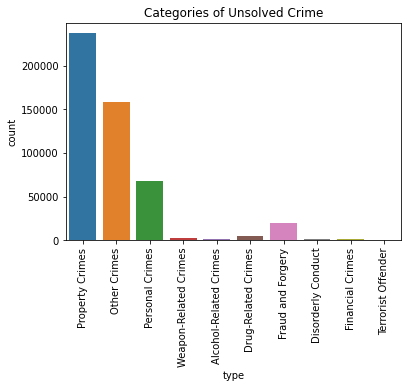

In [17]:
sns.countplot(data=unsolved_crime_data, x='type')
plt.xticks(rotation=90)
plt.title('Categories of Unsolved Crime')
plt.show()

미해결 사건 중 위와 같이 상위 4개 유형 범죄의 발생 수가 상대적으로 높으므로 이를 감소시키는 게 중요함

###### 3) 연도별 미해결 사건 추이

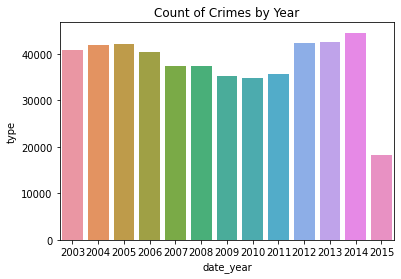

In [18]:
temp_var = unsolved_crime_data.groupby('date_year').agg({'type': 'count'}).reset_index()
sns.barplot(data=temp_var, x='date_year', y='type')
plt.title('Count of Crimes by Year')
plt.show()

2015년 중간에 데이터 수집이 중단되었을 가능성이 있음

###### 4) 2015년 데이터 분포

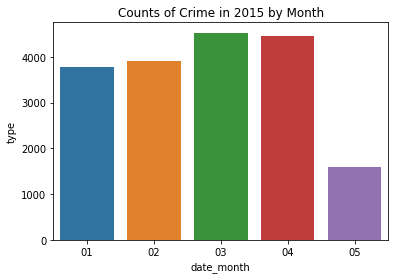

In [19]:
temp_var = unsolved_crime_data[unsolved_crime_data['date_year']=='2015'].groupby('date_month').agg({'type':'count'}).reset_index()
sns.barplot(data=temp_var, x='date_month', y='type')
plt.title('Counts of Crime in 2015 by Month')
plt.show()

2015년 5월 일부까지만 포함된 데이터인 걸 알 수 있음

## 3. 분석

### 주제 1. 미해결 사건 분석 및 해결 대책 수립
* 가설: 범죄 취약 지역, 방범 시설 미흡 등의 원인으로 인해 **미해결 사건의 비율이 상대적으로 높은 지역이 존재할 것**이다.
* 분석: 미해결 사건이 상대적으로 높은 이유를 지역적 특성과 연관지어 분석하고, 이에 대한 대책을 수립한다.

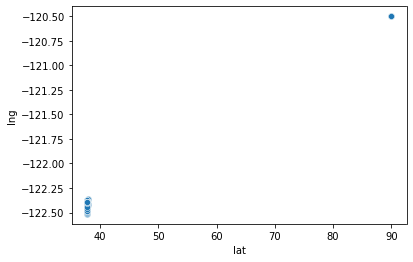

In [20]:
sns.scatterplot(data=unsolved_crime_data, x='lat', y='lng')
plt.show()

이상치 때문에 시각화가 제대로 안 되므로 이상치를 제거하고 다시 수행

###### 1) 이상치 처리
데이터 분포를 제대로 파악하기 위해 위도가 50 이상, 경도가 -122 이상인 데이터는 삭제

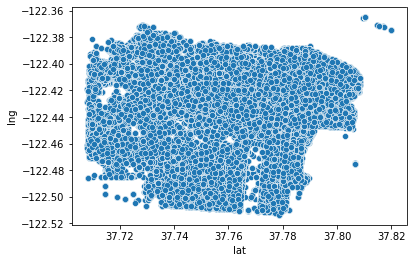

In [21]:
# 이상치 삭제
temp_var = unsolved_crime_data[(unsolved_crime_data['lat']<=50)&(unsolved_crime_data['lng']<=-122)]

# 분포 확인
sns.scatterplot(data=temp_var, x='lat', y='lng')
plt.show()

In [22]:
temp_var

,Dates,date_year,date_month,date_hour,DayOfWeek,Category,type,Descript,PdDistrict,Resolution,Address,lat,lng
3,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,37.800873,-122.426995
4,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,37.771541,-122.438738
5,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM UNLOCKED AUTO,INGLESIDE,NONE,0 Block of TEDDY AV,37.713431,-122.403252
6,2015-05-13 23:30:00,2015,05,23,Wednesday,VEHICLE THEFT,Property Crimes,STOLEN AUTOMOBILE,INGLESIDE,NONE,AVALON AV / PERU AV,37.725138,-122.423327
7,2015-05-13 23:30:00,2015,05,23,Wednesday,VEHICLE THEFT,Property Crimes,STOLEN AUTOMOBILE,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,37.727564,-122.371274
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,2003,01,00,Monday,ROBBERY,Personal Crimes,ROBBERY ON THE STREET WITH A GUN,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,37.714056,-122.459033
878045,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,INGLESIDE,NONE,600 Block of EDNA ST,37.731948,-122.447364
878046,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,SOUTHERN,NONE,5TH ST / FOLSOM ST,37.780266,-122.403390
878047,2003-01-06 00:01:00,2003,01,00,Monday,VANDALISM,Other Crimes,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",SOUTHERN,NONE,TOWNSEND ST / 2ND ST,37.780607,-122.390531


이상치를 제거하고 나니 데이터 분포는 확인할 수 있지만,
데이터 수가 너무 많아서 어느 지역에 얼마나 밀집되었는지 scatter plot으로는 파악이 불가능함

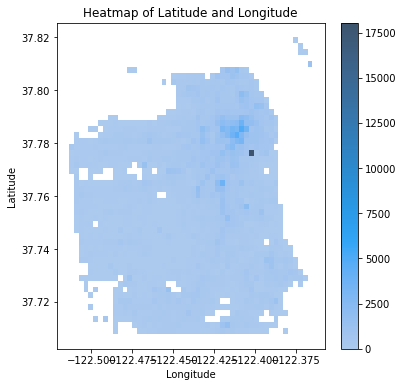

In [23]:
fig, ax = plt.subplots(figsize=(6, 6))

sns.histplot(data=temp_var, x='lng', y='lat', bins=50, cbar=True)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heatmap of Latitude and Longitude')

plt.show()

미해결 사건이 밀집된 특정 위도, 경도를 도출할 수 있음
\> 위도, 경도를 구간화해서 구간별 미해결 사건의 비율 비교

###### 2) 구간화
정확한 비율을 확인하기 위해 구간화

In [24]:
# 위도, 경도 범위
lat_min, lat_max = temp_var['lat'].min(), temp_var['lat'].max()
lng_min, lng_max = temp_var['lng'].min(), temp_var['lng'].max()

# 구간 설정
lat_bins = np.linspace(lat_min, lat_max, 7)
lng_bins = np.linspace(lng_min, lng_max, 7)

# 구간 할당
temp_var.loc[:, 'lat_group'] = pd.cut(temp_var['lat'], bins=lat_bins, labels=[1 ,2 ,3 ,4 ,5 ,6])
temp_var.loc[:, 'lng_group'] = pd.cut(temp_var['lng'], bins=lng_bins, labels=[1 ,2 ,3 ,4 ,5 ,6])

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


###### 3) 구간별 미해결 사건 비율 확인

/tmp/ipykernel_177/3530009040.py:14: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  ax2.pie(lng_ratio.values,


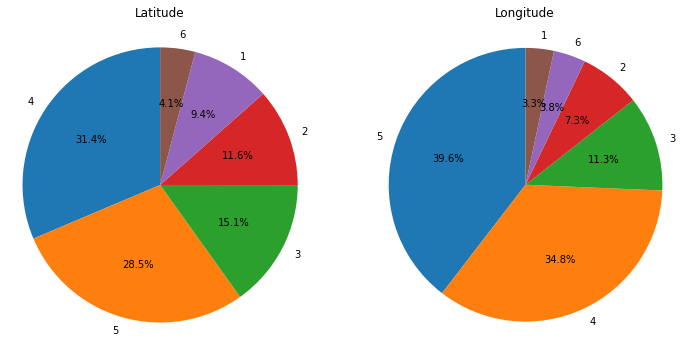

In [25]:
# 비율 계산
lat_ratio = temp_var['lat_group'].value_counts(normalize=True)
lng_ratio = temp_var['lng_group'].value_counts(normalize=True)

# 파이차트
fig1, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax1.pie(lat_ratio.values,
        labels=lat_ratio.index,
        autopct='%1.1f%%',
        startangle=90)
ax1.axis('equal')
ax1.set_title('Latitude')

ax2.pie(lng_ratio.values,
        labels=lng_ratio.index,
        autopct='%1.1f%%',
        startangle=90)
ax2.axis('equal')
ax2.set_title('Longitude')

plt.show()

위도와 경도 모두 4~5 구간에서 미해결 사건의 비율이 상당히 높은 걸 확인할 수 있다.

In [26]:
print(f'위도: {lat_bins[3]} ~ {lat_bins[5]}')
print(f'경도: {lng_bins[3]} ~ {lng_bins[5]}')

위도: 37.763927257355256 ~ 37.801292747316424
경도: -122.439289779185 ~ -122.389721589115


위의 지역 범위에서 미해결 사건의 비율이 전체 지역의 약 60~75%를 차지하고 있었다. 해당 지역에서 미해결 사건의 비율이 이렇게까지 높은 원인을 찾고 대책을 수립해야 한다. 또한, 위에서 특정한 지역의 해당 지역 관할 경찰서와 미해결 사건 사이에 상관관계가 있는지 추가로 파악해 본다.

###### 4) 해당 지역의 관할 구역 확인

In [27]:
# 사건 미해결율이 높은 지역(4, 5 구간) 저장
temp_temp_var = temp_var[((temp_var['lat_group']==4)|(temp_var['lat_group']==5))&((temp_var['lng_group']==4)|(temp_var['lng_group']==5))]

/opt/conda/lib/python3.9/site-packages/IPython/core/pylabtools.py:137: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


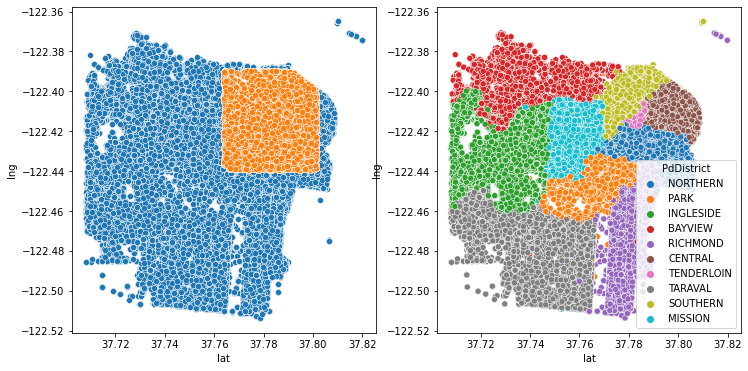

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

sns.scatterplot(data=temp_var, x='lat', y='lng', ax=ax1)
sns.scatterplot(data=temp_temp_var, x='lat', y='lng', ax=ax1)

sns.scatterplot(data=temp_var, x='lat', y='lng', hue='PdDistrict', ax=ax2)
plt.show()

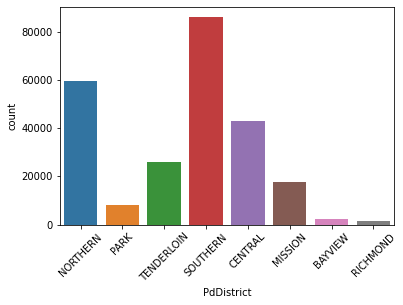

In [29]:
sns.countplot(data=temp_temp_var, x='PdDistrict')
plt.xticks(rotation=45)
plt.show()

## 전체 10개의 관할 경찰서 중 8개가 추출되었고, 위의 그래프와 같이 특정 관할 구역에서 미해결 사건의 수가 많았다.

In [30]:
data

,Dates,date_year,date_month,date_hour,DayOfWeek,Category,type,Descript,PdDistrict,Resolution,Address,lat,lng
0,2015-05-13 23:53:00,2015,05,23,Wednesday,WARRANTS,Other Crimes,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,37.774599,-122.425892
3,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,37.800873,-122.426995
4,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,37.771541,-122.438738
5,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM UNLOCKED AUTO,INGLESIDE,NONE,0 Block of TEDDY AV,37.713431,-122.403252
6,2015-05-13 23:30:00,2015,05,23,Wednesday,VEHICLE THEFT,Property Crimes,STOLEN AUTOMOBILE,INGLESIDE,NONE,AVALON AV / PERU AV,37.725138,-122.423327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,2003,01,00,Monday,ROBBERY,Personal Crimes,ROBBERY ON THE STREET WITH A GUN,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,37.714056,-122.459033
878045,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,INGLESIDE,NONE,600 Block of EDNA ST,37.731948,-122.447364
878046,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,SOUTHERN,NONE,5TH ST / FOLSOM ST,37.780266,-122.403390
878047,2003-01-06 00:01:00,2003,01,00,Monday,VANDALISM,Other Crimes,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",SOUTHERN,NONE,TOWNSEND ST / 2ND ST,37.780607,-122.390531


In [31]:

## 데이터와 연도를 받아와서 해당 연도로 관할별 반환
def group_pddistrict_by_year(data,year):

    data_filtered = data[data['date_year'] == year]

    # '저장할 딕셔너리.
    district_data_dict = {}

    # 'PdDistrict' 값들의 고유 리스트 저장.
    pd_districts = data_filtered['PdDistrict'].unique()

    # 각 'PdDistrict' 별로 데이터프레임을 저장.
    for pd_district in pd_districts:
        district_data_dict[pd_district] = data_filtered[data_filtered['PdDistrict'] == pd_district]

    return district_data_dict
#데이터딕셔너리를 받아서 해당 딕셔너리 안에 있는 데이터 프레임 별로 시각화하는 함수 
def plot_none_ratio_by_type_and_district(data_dic):
    # 나누어진 딕셔너리의 데이터 프레임을 합친다
    combined_df = pd.concat(data_dic.values(), ignore_index=True)

    # type, 관할 지역 별로 해결한 value값을 계산해 넣는다
    district_type_none_ratio = combined_df.groupby(['PdDistrict', 'type'])['Resolution'].apply(lambda x: (x == 'NONE').mean()).reset_index()

    g = sns.FacetGrid(district_type_none_ratio, col='PdDistrict', col_wrap=5, height=4)
    g.map(sns.barplot, 'type', 'Resolution', palette='viridis')
    g.set_axis_labels('Type', 'NONE Ratio')
    g.set_titles(col_template="{col_name}")
    g.set_xticklabels(rotation=45, ha='right')
    g.add_legend(title='Type')
    g.set(xticks=range(len(district_type_none_ratio['type'].unique())))
    g.set_xticklabels(labels=district_type_none_ratio['type'].unique(), rotation=45, ha='right')

    plt.tight_layout()
    plt.show()



/opt/conda/lib/python3.9/site-packages/seaborn/axisgrid.py:670: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


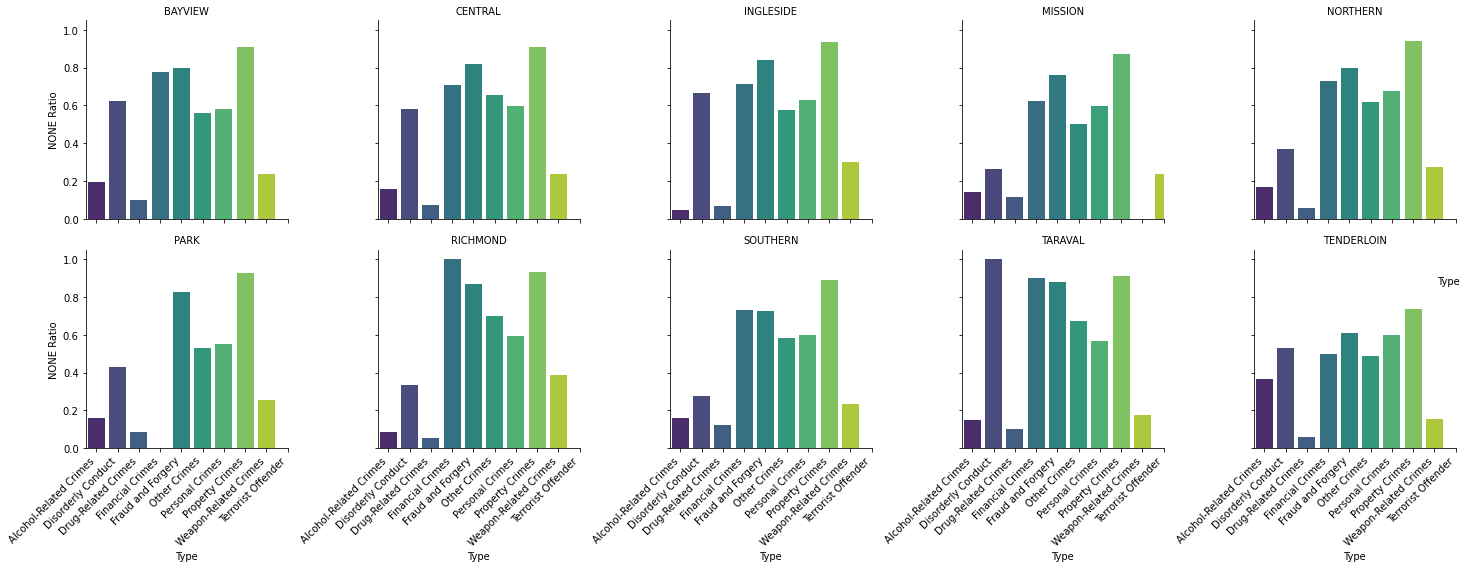

In [32]:

data_2014 = group_pddistrict_by_year(data, '2014')
plot_none_ratio_by_type_and_district(data_2014)

## 해당 시각화한 자료로는 관할 지역별로 어떤 관할이 미해결 사건이 많은지 한눈에 보기 어려움

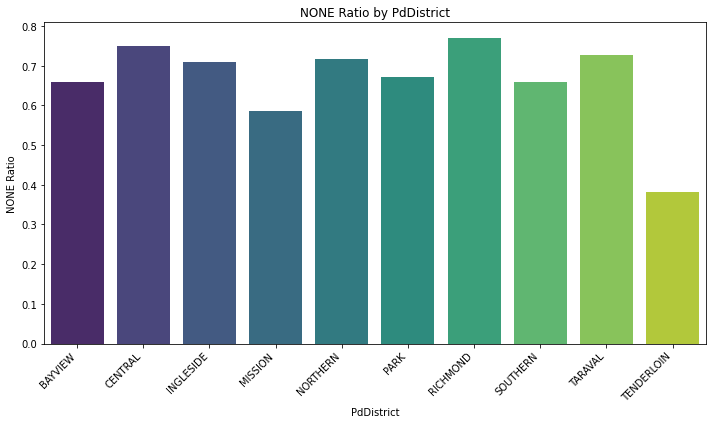

In [33]:
selected_columns = ['PdDistrict', 'Resolution']
df_selected = data[selected_columns]

## mean을 사용하는 이유는 차지하는 비율을 알기에 사용
district_none_ratio = df_selected.groupby('PdDistrict')['Resolution'].apply(lambda x: (x == 'NONE').mean()).reset_index()


plt.figure(figsize=(10, 6))
sns.barplot(x='PdDistrict', y='Resolution', data=district_none_ratio, palette='viridis')
plt.xlabel('PdDistrict')
plt.ylabel('NONE Ratio')
plt.title('NONE Ratio by PdDistrict')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 다른 지역에 비해 thenderlion이 매우 낮았으며, richmond가 제일 검거율이 낮았다.
## 두 지역의 범죄인 비율을 시각화해서 보았다.

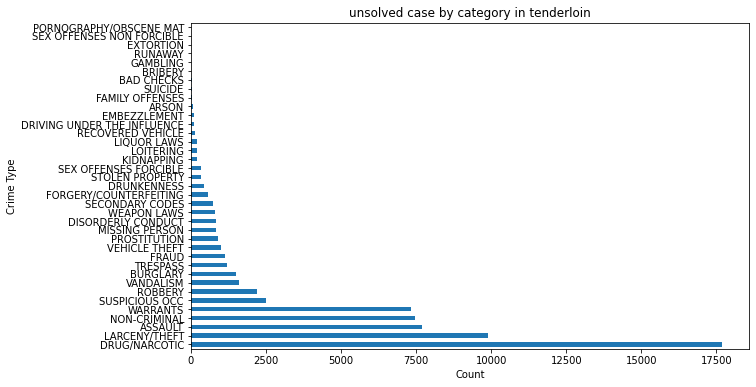

In [34]:
# tenderloin데이터 시각화
data_loin = data[data['PdDistrict']=='TENDERLOIN']
type_counts = data_loin['Category'].value_counts()
plt.figure(figsize=(10, 6))  
type_counts.plot(kind='barh')  
plt.xlabel('Count')  
plt.ylabel('Crime Type') 
plt.title('unsolved case by category in tenderloin')  

plt.show()

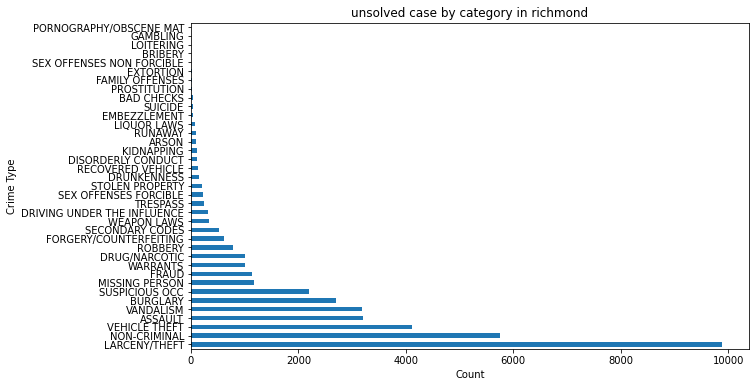

In [35]:
###
data_rich = data[data['PdDistrict']=='RICHMOND']
type_counts = data_rich['Category'].value_counts()
plt.figure(figsize=(10, 6))  
type_counts.plot(kind='barh')  
plt.xlabel('Count')  
plt.ylabel('Crime Type') 
plt.title('unsolved case by category in richmond')  

plt.show()

## 미해결 사건이 많은 richmond의 category별 case를 보았을때 절도사건이 가장 많았으며, 미해결 사건이 적은 tenderloin의 category별 case를 보았을때 마약사건이 가장 많았다.
### 이를 통해서 각 지역별로 나우었을때 사건 case별 미해결 사건을 분석해보았다 

In [36]:
### 누적막대그래프를 그리는 함수
def plot_crime_resolution(data, category):

    category_data = data[data['Category'] == category]


    crime_counts = category_data['PdDistrict'].value_counts().reset_index()
    crime_counts.columns = ['PdDistrict', 'Total Crime']


    none_resolution_counts = category_data[category_data['Resolution'] == 'NONE']['PdDistrict'].value_counts().reset_index()
    none_resolution_counts.columns = ['PdDistrict', 'None Resolution']


    merged_data = pd.merge(crime_counts, none_resolution_counts, on='PdDistrict')


    merged_data = merged_data.sort_values(by='PdDistrict')


    plt.figure(figsize=(10, 6))
    sns.set(style="whitegrid")
    sns.barplot(x="PdDistrict", y="Total Crime", data=merged_data, color='blue', label='Total Crime')
    sns.barplot(x="PdDistrict", y="None Resolution", data=merged_data, color='green', label='None Resolution')
    plt.xlabel('PdDistrict')
    plt.ylabel('Count')
    plt.title(f'{category}')
    plt.legend()
    plt.show()
    

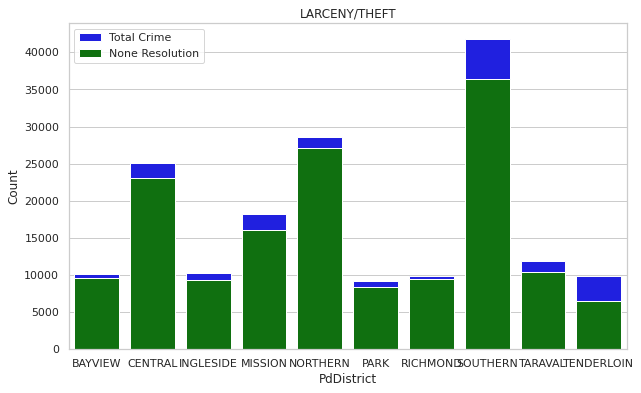

In [37]:
plot_crime_resolution(data, "LARCENY/THEFT")  

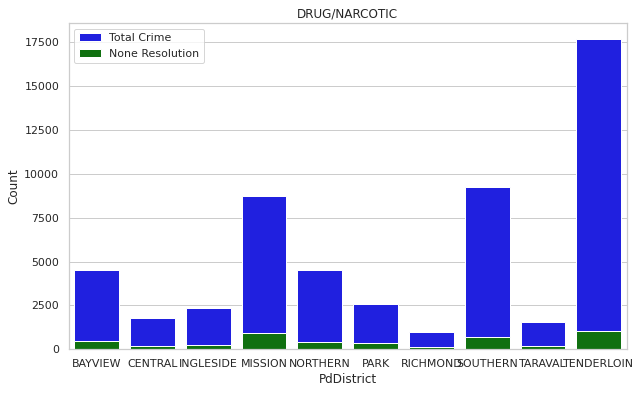

In [38]:
plot_crime_resolution(data, "DRUG/NARCOTIC")  

### 전반적으로 모든 관할 구역에서 마약사건은 해결율이 높지만, 절도 사건은 해결율이 높지 않다. 그이유를 생각해 보았을 때 경찰의 인력을 단순 도난 사건에 투입을 하지 않는다고 생각을 하였다

--------------
### 사건의 발생율을 낮추고 해결율을 높이기 위한 방법을 추론하기 위하여 해당 사건이 가장 많이 발생하는 지역을 확인하여서 범죄 지역에 대한 순찰을 강화
### 하지만 데이터가 너무 많으며, 지역이 너무 넓어 가장 많이 발생하는 위경도의 구역에서 분석 진행

In [39]:
### 가장 많이 사건이 발생하는 위경도 지역
min_latitude = 37.763927257355256
max_latitude = 37.801292747316424
min_longitude = -122.439289779185
max_longitude = -122.389721589115

filtered_data = data[(data['lat'] >= min_latitude) & (data['lat'] <= max_latitude) & (data['lng'] >= min_longitude) & (data['lng'] <= max_longitude)]

filtered_data

,Dates,date_year,date_month,date_hour,DayOfWeek,Category,type,Descript,PdDistrict,Resolution,Address,lat,lng
0,2015-05-13 23:53:00,2015,05,23,Wednesday,WARRANTS,Other Crimes,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,37.774599,-122.425892
3,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,37.800873,-122.426995
4,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,37.771541,-122.438738
12,2015-05-13 22:30:00,2015,05,22,Wednesday,VANDALISM,Other Crimes,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",TENDERLOIN,NONE,TURK ST / JONES ST,37.783004,-122.412414
13,2015-05-13 22:06:00,2015,05,22,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,FILLMORE ST / GEARY BL,37.784353,-122.432915
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878036,2003-01-06 00:55:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,PETTY THEFT SHOPLIFTING,NORTHERN,NONE,1300 Block of WEBSTER ST,37.783030,-122.431046
878037,2003-01-06 00:55:00,2003,01,00,Monday,VANDALISM,Other Crimes,"MALICIOUS MISCHIEF, VANDALISM",NORTHERN,NONE,1300 Block of WEBSTER ST,37.783030,-122.431046
878038,2003-01-06 00:42:00,2003,01,00,Monday,WARRANTS,Other Crimes,ENROUTE TO OUTSIDE JURISDICTION,TENDERLOIN,"ARREST, BOOKED",TAYLOR ST / GEARY ST,37.786941,-122.411519
878046,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,SOUTHERN,NONE,5TH ST / FOLSOM ST,37.780266,-122.403390


In [1]:
# filtered_data = filtered_data [filtered_data ['Category'] != 'NON-CRIMINAL']
# filtered_data= filtered_data[filtered_data['date_year'].isin(['2013', '2014', '2015'])]
# import folium
# from folium import plugins

# locations = filtered_data[['lat', 'lng', 'Category', 'type']]
# map_center = [locations['lat'].median(), locations['lng'].median()]
# m = folium.Map(location=map_center, zoom_start=12)
# marker_cluster = plugins.MarkerCluster().add_to(m)
# for index, row in locations.iterrows():
#     lat, lon, category, crime_type = row['lat'], row['lng'], row['Category'], row['type']
#     folium.Marker([lat, lon], popup=f"Category: {category}, Type: {crime_type}").add_to(marker_cluster)
# folium.LayerControl().add_to(m)
# m

In [41]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
X = filtered_data[['lat', 'lng']]
# 정규화 하는 이유는 위도와 경도의 크기가 다르기 때문에
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
## 값을 바꾸면 다르게 나옴. 
epsilon = 0.01  
min_samples = 200 
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(X_scaled)
labels = dbscan.labels_
filtered_data['Cluster'] = labels
print(filtered_data['Cluster'].value_counts())
for cluster in filtered_data['Cluster'].unique():
    cluster_data = filtered_data[filtered_data['Cluster'] == cluster]
    print(f"Cluster {cluster} - Size: {len(cluster_data)}")
    print(cluster_data.head())
data

-1     59659
 1      3542
 9       688
 13      598
 14      447
 10      414
 16      375
 5       340
 17      309
 6       302
 7       269
 3       246
 11      244
 18      226
 19      223
 4       219
 0       213
 2       212
 20      211
 12      210
 15      208
 8       207
Name: Cluster, dtype: int64
Cluster -1 - Size: 59659
                  Dates date_year date_month date_hour  DayOfWeek  \
0   2015-05-13 23:53:00      2015         05        23  Wednesday   
3   2015-05-13 23:30:00      2015         05        23  Wednesday   
4   2015-05-13 23:30:00      2015         05        23  Wednesday   
12  2015-05-13 22:30:00      2015         05        22  Wednesday   
13  2015-05-13 22:06:00      2015         05        22  Wednesday   

         Category             type                                   Descript  \
0        WARRANTS     Other Crimes                             WARRANT ARREST   
3   LARCENY/THEFT  Property Crimes               GRAND THEFT FROM LOCKED AUTO   
4  

,Dates,date_year,date_month,date_hour,DayOfWeek,Category,type,Descript,PdDistrict,Resolution,Address,lat,lng
0,2015-05-13 23:53:00,2015,05,23,Wednesday,WARRANTS,Other Crimes,WARRANT ARREST,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,37.774599,-122.425892
3,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,NORTHERN,NONE,1500 Block of LOMBARD ST,37.800873,-122.426995
4,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,PARK,NONE,100 Block of BRODERICK ST,37.771541,-122.438738
5,2015-05-13 23:30:00,2015,05,23,Wednesday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM UNLOCKED AUTO,INGLESIDE,NONE,0 Block of TEDDY AV,37.713431,-122.403252
6,2015-05-13 23:30:00,2015,05,23,Wednesday,VEHICLE THEFT,Property Crimes,STOLEN AUTOMOBILE,INGLESIDE,NONE,AVALON AV / PERU AV,37.725138,-122.423327
...,...,...,...,...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,2003,01,00,Monday,ROBBERY,Personal Crimes,ROBBERY ON THE STREET WITH A GUN,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,37.714056,-122.459033
878045,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,INGLESIDE,NONE,600 Block of EDNA ST,37.731948,-122.447364
878046,2003-01-06 00:01:00,2003,01,00,Monday,LARCENY/THEFT,Property Crimes,GRAND THEFT FROM LOCKED AUTO,SOUTHERN,NONE,5TH ST / FOLSOM ST,37.780266,-122.403390
878047,2003-01-06 00:01:00,2003,01,00,Monday,VANDALISM,Other Crimes,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",SOUTHERN,NONE,TOWNSEND ST / 2ND ST,37.780607,-122.390531


In [42]:
cluster_centers = filtered_data.groupby('Cluster')[['lat', 'lng']].agg(lambda x: x.value_counts().idxmax()).reset_index()
print(cluster_centers)
cluster_centers.head()

    Cluster        lat         lng
0        -1  37.779944 -122.414318
1         0  37.783030 -122.431046
2         1  37.775421 -122.403405
3         2  37.780478 -122.412515
4         3  37.785094 -122.407845
5         4  37.786734 -122.405895
6         5  37.769247 -122.426956
7         6  37.785269 -122.403070
8         7  37.781751 -122.411071
9         8  37.765718 -122.409530
10        9  37.784189 -122.407634
11       10  37.764221 -122.419658
12       11  37.783992 -122.408068
13       12  37.783510 -122.405395
14       13  37.765050 -122.419672
15       14  37.785063 -122.406521
16       15  37.777824 -122.407999
17       16  37.786565 -122.407244
18       17  37.783386 -122.409854
19       18  37.785207 -122.406691
20       19  37.782231 -122.410294
21       20  37.782793 -122.414056


,Cluster,lat,lng
0,-1,37.779944,-122.414318
1,0,37.783030,-122.431046
2,1,37.775421,-122.403405
3,2,37.780478,-122.412515
4,3,37.785094,-122.407845


In [2]:
# m = folium.Map(location=[37.782073, -122.412224], zoom_start=13)

# # 클러스터별로 마커 추가
# for index, row in cluster_centers.iterrows():
#     folium.Marker([row['lat'], row['lng']],
#                   popup=f'Cluster: {row["Cluster"]}',
#                   icon=folium.Icon(icon='star',color='red')).add_to(m)
# m

### 모델을 사용한 이유는 dbscan을 통해서 사건이 일어난 위경도의 값들을 군집화하고, 해당 클러스터에 중앙값들을 기준으로 순찰을 할 위치를 마커로 표시하기 위하여서 사용하였다.


-------------------------
## 주제 2


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from collections import Counter
import matplotlib as mpl
mpl.get_cachedir()
path = os.getenv('HOME') + '/aiffel/datacon/train.csv'
data = pd.read_csv(path)


In [45]:
data
data.info()
unique_category = data['Category'].unique()
nunique_category= data['Category'].nunique()
unique_solution = data['Resolution'].unique()

print(unique_category)
print(nunique_category)
print(data.columns)
print(unique_solution)
data
data2=data[data['Category']=='TREA']
data2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 878049 entries, 0 to 878048
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Dates       878049 non-null  object 
 1   Category    878049 non-null  object 
 2   Descript    878049 non-null  object 
 3   DayOfWeek   878049 non-null  object 
 4   PdDistrict  878049 non-null  object 
 5   Resolution  878049 non-null  object 
 6   Address     878049 non-null  object 
 7   X           878049 non-null  float64
 8   Y           878049 non-null  float64
dtypes: float64(2), object(7)
memory usage: 60.3+ MB
['WARRANTS' 'OTHER OFFENSES' 'LARCENY/THEFT' 'VEHICLE THEFT' 'VANDALISM'
 'NON-CRIMINAL' 'ROBBERY' 'ASSAULT' 'WEAPON LAWS' 'BURGLARY'
 'SUSPICIOUS OCC' 'DRUNKENNESS' 'FORGERY/COUNTERFEITING' 'DRUG/NARCOTIC'
 'STOLEN PROPERTY' 'SECONDARY CODES' 'TRESPASS' 'MISSING PERSON' 'FRAUD'
 'KIDNAPPING' 'RUNAWAY' 'DRIVING UNDER THE INFLUENCE'
 'SEX OFFENSES FORCIBLE' 'PROSTITUTION' '

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
21002,2015-02-03 17:05:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Tuesday,BAYVIEW,NONE,300 Block of 20TH ST,-122.386105,37.760692
93716,2014-02-17 06:38:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Monday,MISSION,"ARREST, BOOKED",500 Block of CASTRO ST,-122.434995,37.760070
107733,2013-11-30 05:59:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Saturday,NORTHERN,"ARREST, BOOKED",700 Block of POLK ST,-122.419250,37.783807
192190,2012-10-20 22:27:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Saturday,BAYVIEW,NONE,1300 Block of ARMSTRONG AV,-122.387620,37.723535
316490,2010-12-31 16:20:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Friday,CENTRAL,"ARREST, BOOKED",2300 Block of STOCKTON ST,-122.410661,37.807428
337880,2010-09-09 11:55:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Thursday,BAYVIEW,NONE,1000 Block of IOWA ST,-122.391708,37.753872


In [46]:
# 가장많이 나오는 단어 찾기 
most_word = Counter(data['Category']).most_common()
print(most_word)

[('LARCENY/THEFT', 174900), ('OTHER OFFENSES', 126182), ('NON-CRIMINAL', 92304), ('ASSAULT', 76876), ('DRUG/NARCOTIC', 53971), ('VEHICLE THEFT', 53781), ('VANDALISM', 44725), ('WARRANTS', 42214), ('BURGLARY', 36755), ('SUSPICIOUS OCC', 31414), ('MISSING PERSON', 25989), ('ROBBERY', 23000), ('FRAUD', 16679), ('FORGERY/COUNTERFEITING', 10609), ('SECONDARY CODES', 9985), ('WEAPON LAWS', 8555), ('PROSTITUTION', 7484), ('TRESPASS', 7326), ('STOLEN PROPERTY', 4540), ('SEX OFFENSES FORCIBLE', 4388), ('DISORDERLY CONDUCT', 4320), ('DRUNKENNESS', 4280), ('RECOVERED VEHICLE', 3138), ('KIDNAPPING', 2341), ('DRIVING UNDER THE INFLUENCE', 2268), ('RUNAWAY', 1946), ('LIQUOR LAWS', 1903), ('ARSON', 1513), ('LOITERING', 1225), ('EMBEZZLEMENT', 1166), ('SUICIDE', 508), ('FAMILY OFFENSES', 491), ('BAD CHECKS', 406), ('BRIBERY', 289), ('EXTORTION', 256), ('SEX OFFENSES NON FORCIBLE', 148), ('GAMBLING', 146), ('PORNOGRAPHY/OBSCENE MAT', 22), ('TREA', 6)]


In [47]:
# 세부 범죄내용을 더 큰 범주로 묶기 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from collections import Counter


data_div = data
data_div
property_crimes = ['LARCENY/THEFT', 'VEHICLE THEFT', 'BURGLARY', 'STOLEN PROPERTY', 'ARSON', 'EXTORTION']
personal_crimes = ['ASSAULT','KIDNAPPING','SEX OFFENSES FORCIBLE','ROBBERY','HOMICIDE','FAMILY OFFENSES','TRESPASS']
alcohol_related_crimes = ['DRUNKENNESS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS']
disorderly_conduct = ['DISORDERLY CONDUCT','LOITERING']
fraud_forgery=['FORGERY/COUNTERFEITING','FRAUD']
weapon_related_crimes = ['WEAPON LAWS']
drug_related_crimes = ['DRUG/NARCOTIC']
financial_crimes =['BAD CHECKS','EMBEZZLEMENT','BRIBERY']
terrorist_offender=['TREA']
data_div['type'] = data_div['Category'].apply(lambda x: 'property crimes' if x in property_crimes else
                                          ('personal crimes' if x in personal_crimes else
                                          ('alcohol-related crimes' if x in alcohol_related_crimes else
                                          ('disorderly conduct' if x in disorderly_conduct else
                                          ('fraud and forgery' if x in fraud_forgery else
                                          ('weapon-related crimes' if x in weapon_related_crimes else
                                          ('drug-related crimes' if x in drug_related_crimes else
                                          ('financial crimes' if x in financial_crimes else
                                          ('Terrorist Offender' if x in terrorist_offender else 'other')))))))))


In [48]:
# 날짜데이터를 나눠서 정리
import matplotlib.pyplot as plt
data_plt = data_div
data_plt['date_year'] = data_plt['Dates'].apply(lambda x: x[:4])
data_plt['date_month'] = data_plt['Dates'].apply(lambda x: x[5:7])
data_plt['date_hour'] = data_plt['Dates'].apply(lambda x: x[10:13])
data_plt['date_day'] = data_plt['Dates'].apply(lambda x: x[8:10])

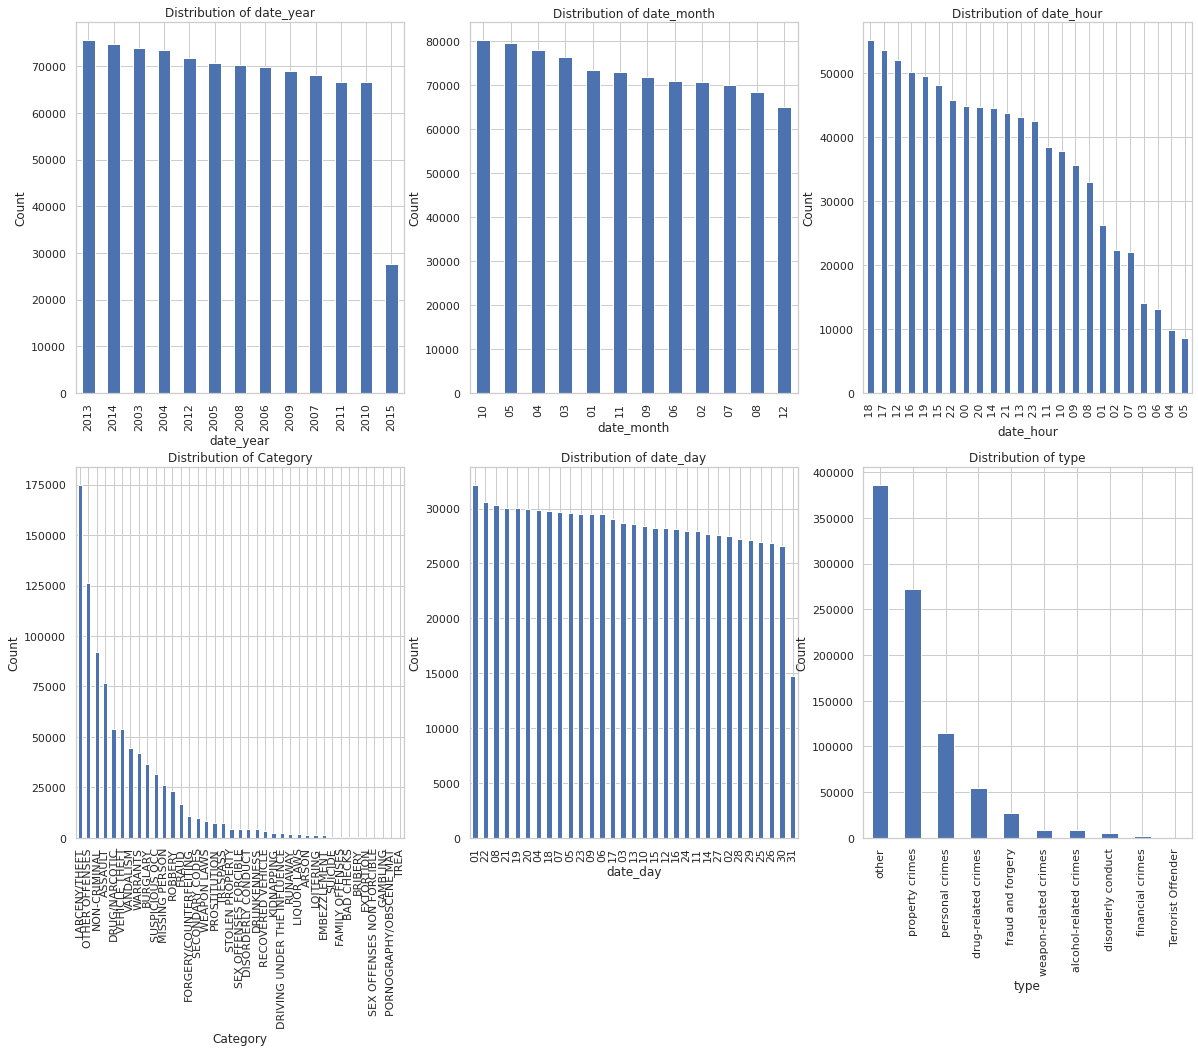

In [49]:
# data와 범죄 유형을 시각화 하기 
figure, axes = plt.subplots(2, 3,figsize=(20, 15))
col_plt = ['date_year', 'date_month' ,'date_hour', 'Category','date_day','type']

for i, col in enumerate(col_plt):
    plt.subplot(2, 3, i + 1)
    data_plt[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')


plt.show()

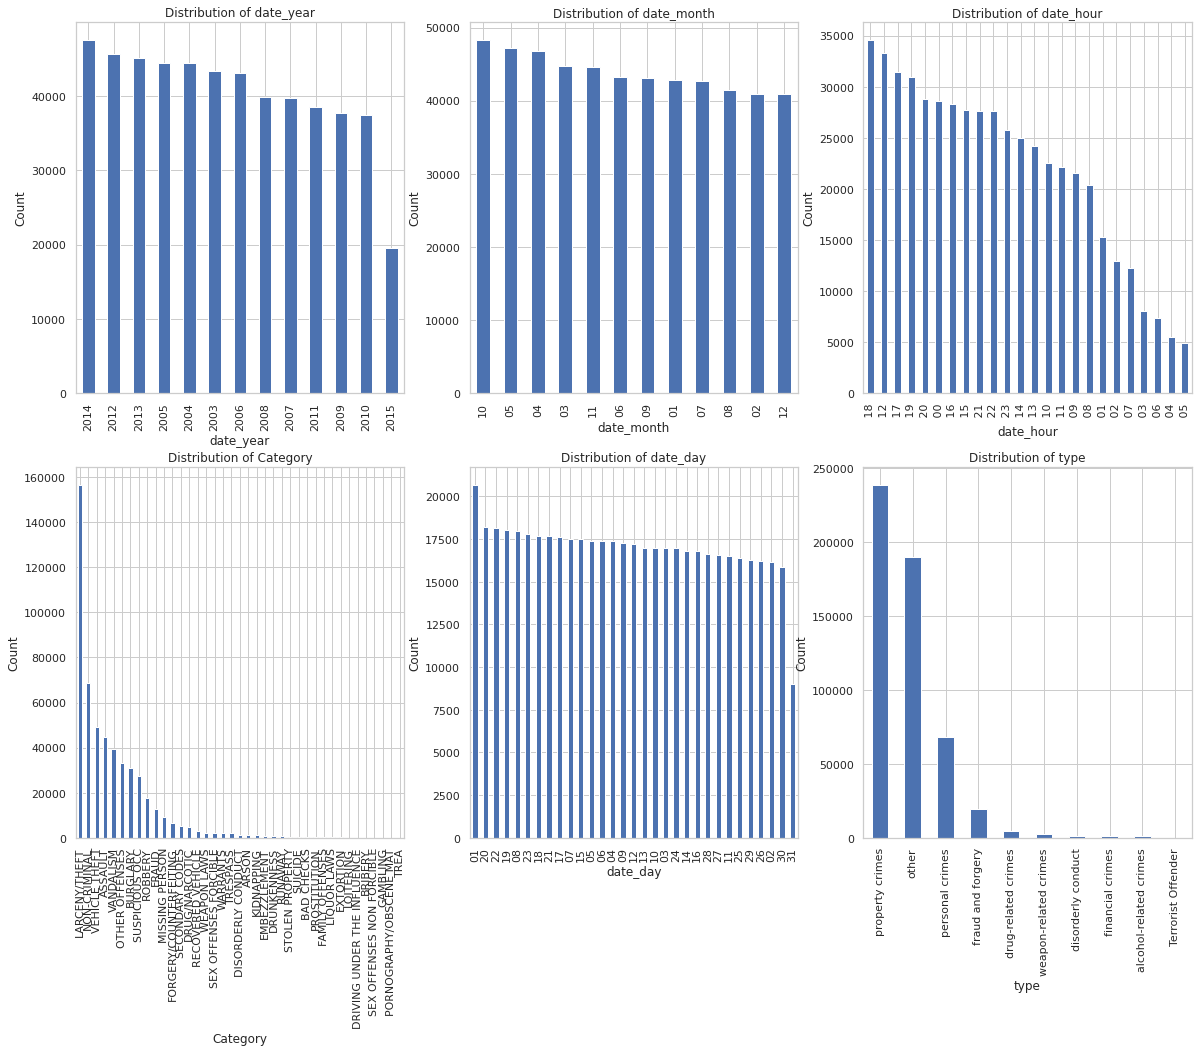

In [50]:
figure, axes = plt.subplots(2, 3,figsize=(20, 15))
col_plt = ['date_year', 'date_month' ,'date_hour', 'Category','date_day','type']
data_notnone=data_plt[data_plt['Resolution']=='NONE']

for i, col in enumerate(col_plt):
    plt.subplot(2, 3, i + 1)
    data_notnone[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')


plt.show()

In [51]:
data_notnone[data_notnone['type']=='Terrorist Offender']

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,type,date_year,date_month,date_hour,date_day
21002,2015-02-03 17:05:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Tuesday,BAYVIEW,NONE,300 Block of 20TH ST,-122.386105,37.760692,Terrorist Offender,2015,02,17,03
192190,2012-10-20 22:27:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Saturday,BAYVIEW,NONE,1300 Block of ARMSTRONG AV,-122.387620,37.723535,Terrorist Offender,2012,10,22,20
337880,2010-09-09 11:55:00,TREA,TRESPASSING OR LOITERING NEAR POSTED INDUSTRIA...,Thursday,BAYVIEW,NONE,1000 Block of IOWA ST,-122.391708,37.753872,Terrorist Offender,2010,09,11,09


## EDA
먼저 센프란시스코의 데이터를 살펴보자. 각 연도별로 확인된 범죄의 갯수를 살펴보고 시각화해보자

In [52]:
# 각 연도별로 범죄건수 확인
san_year = data['date_year'].value_counts() 
san_year

2013    75606
2014    74766
2003    73902
2004    73422
2012    71731
2005    70779
2008    70174
2006    69909
2009    69000
2007    68015
2011    66619
2010    66542
2015    27584
Name: date_year, dtype: int64

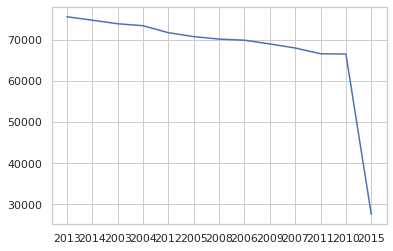

In [53]:
# 시각화하기 

plt.plot(san_year)
plt.show()

2015년에 범죄 발생률이 현저히 떨어졌다 왜일까?

In [54]:
# 2015년과 그 전년도에서는 어떤 범죄가 일어났는지 살펴보기

data_2015 = data[data['date_year'] == '2015'] 
data_other = data[data['date_year'] != '2015']

# 2015년 데이터에 모두 기록이 되었는지 살펴보기
data_2015['date_month'].value_counts()


03    6851
04    6609
02    6008
01    5866
05    2250
Name: date_month, dtype: int64

2015년의 데이터가 낮았던 이유는 5월까지만 데이터가 취합되어 있기 때문이다. 따라서 2015년에 범죄율이 낮아진것이 아니다. 그렇다면 센프란시스코에서 많이 일어나고 있는 범죄 유형은 무엇인지 파악해보자

In [55]:
# data.head()
data['type'].value_counts()

other                     386205
property crimes           271745
personal crimes           114422
drug-related crimes        53971
fraud and forgery          27288
weapon-related crimes       8555
alcohol-related crimes      8451
disorderly conduct          5545
financial crimes            1861
Terrorist Offender             6
Name: type, dtype: int64

- Dates: 범죄 발생 시간
- Category: 범죄 카테고리
- tyep : 범죄 카테고리를 큰 범쥐로 분류
- Descript: 해당 사건에 대한 설명
- DayOfWeek: 사건이 발생한 요일
- PdDistrict: 관할 경찰서
- Resolution: 해결 방법
- Address: 범죄 장소
- X: 위도
- Y: 경도
- 해당 데이터를 토대

In [56]:
# 각 유형별 범죄사건 개수 확인 
data['type'].value_counts()

other                     386205
property crimes           271745
personal crimes           114422
drug-related crimes        53971
fraud and forgery          27288
weapon-related crimes       8555
alcohol-related crimes      8451
disorderly conduct          5545
financial crimes            1861
Terrorist Offender             6
Name: type, dtype: int64

범죄가 많이 일어나는 순서로 유형을 살펴보면 Property Crimes, Other Crimes, Personal Crimes, Drug-Related Crimes, Fraud and Forgery 이렇게 5개가 가장 높은 것을 알 수 있다. 
이 5개의 세부 범죄 카테고리를 파악하고 시각화해보자. 

In [57]:
# 제일 사건개수가 많은 5개의 범죄유형의 세부 범죄 카테고리가 무엇인지 확인하기

# 각각의 카테고리를 불러오는 함수 
def dataCategory(new_category) :
    category_data = data[data['type'] == new_category ]
    return category_data

# 데이터 저장하기 
property_data = dataCategory('property crimes')
other_data = dataCategory('other')
personal_data = dataCategory('personal crimes')
drug_data = dataCategory('drug-related crimes')
fraud_data = dataCategory('fraud and forgery')

# shape 확인
print('property_data : ' ,property_data.shape ,end ='\n')
print('other_data : ' ,other_data.shape ,end ='\n')
print('personal_data : ' ,personal_data.shape ,end ='\n')
print('drug_data : ' ,drug_data.shape ,end ='\n')
print('fraud_data : ' ,fraud_data.shape)

# 각 범죄별 카테고리 value_count
property_cate = property_data['Category'].value_counts()
other_cate = other_data['Category'].value_counts()
personal_cate = personal_data['Category'].value_counts()
drug_cate = drug_data['Category'].value_counts()
fraud_cate = fraud_data['Category'].value_counts()


property_data :  (271745, 14)
other_data :  (386205, 14)
personal_data :  (114422, 14)
drug_data :  (53971, 14)
fraud_data :  (27288, 14)


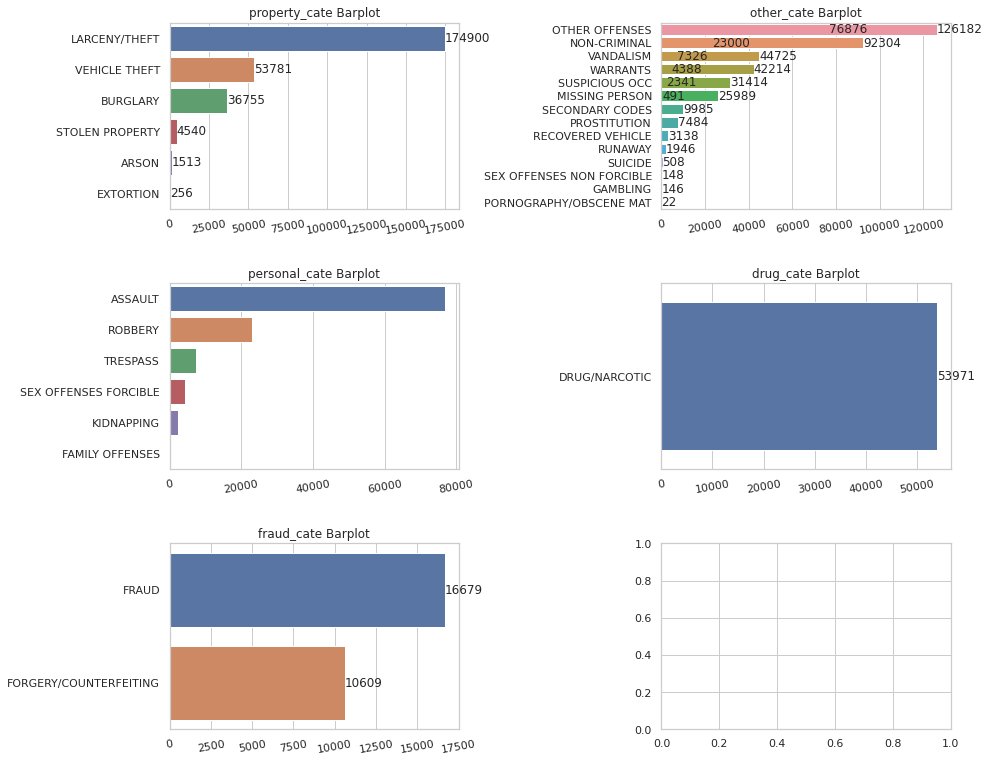

In [58]:
#시각화하기 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 13))

property_cate
ax1 = sns.barplot(x=property_cate.values, y=property_cate.index, ax=axes[0, 0])
# 각 막대 위에 값 표시
for container in ax1.containers:
    ax1.bar_label(container)
ax1.tick_params(axis='x', rotation=10)
ax1.set_title('property_cate Barplot')

# other_cate
ax2 = sns.barplot(x=other_cate.values, y=other_cate.index, ax=axes[0, 1])
# 각 막대 위에 값 표시
for container in ax2.containers:
    ax2.bar_label(container)
ax2.tick_params(axis='x', rotation=10)
ax2.set_title('other_cate Barplot')

# personal_cate
ax3 = sns.barplot(x=personal_cate.values, y=personal_cate.index, ax=axes[1, 0])
for container in ax3.containers:
    ax2.bar_label(container)
ax3.tick_params(axis='x', rotation=10)
ax3.set_title('personal_cate Barplot')
# drug_cate
ax4 = sns.barplot(x=drug_cate.values, y=drug_cate.index, ax=axes[1, 1])
for container in ax4.containers:
    ax4.bar_label(container)
ax4.tick_params(axis='x', rotation=10)
ax4.set_title('drug_cate Barplot')
# fraud_cate
ax5 = sns.barplot(x=fraud_cate.values, y=fraud_cate.index, ax=axes[2, 0])
for container in ax5.containers:
    ax5.bar_label(container)
ax5.tick_params(axis='x', rotation=10)
ax5.set_title('fraud_cate Barplot')

# 서브플롯 간의 가로 간격 및 세로 간격 설정
plt.subplots_adjust(wspace=0.7, hspace=0.4)
plt.show()

각각의 그래프를 확인해보면 
property_data는 
LLARCENY/THEFT : 174900, 
VEHICLE THEFT : 53781, 
BURGLARY : 36755, 
STOLEN PROPERTY : 4540, 

other_data는 
NON-CRIMINAL : 92304, 
VANDALISM : 44725, 
WARRANTS : 42214
SUSPICIOUS OCC : 31414, 
MISSING PERSON : 25989, 

personal_data는
ASSAULT : 76876, 
ROBBERY  : 23000, 
TRESPASS : 7326, 
SEX OFFENSES FORCIBLE : 4388, 
KIDNAPPING : 341, 

drug_data는 DRUG/NARCOTIC : 53971
fraud_data는 FRAUD : 16679, 
FORGERY/COUNTERFEITING : 10609인것을 알 수 있다. 

#### 이 중에서 우리는 가장 문제가 되고 있는 절도사건 대해 분석해보고 절도사건과 상관관계가 있는 범죄유형을 도출하고자 한다

## 샌프란시스코 데이터에서 절도사건과 다른사건들의 데이터를 추출하고 분석하기

In [59]:
# 샌프란시스코 데이터에서 절도사건 데이터를 추출합니다.
property_data.head(10)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y,type,date_year,date_month,date_hour,date_day
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873,property crimes,2015,05,23,13
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541,property crimes,2015,05,23,13
5,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM UNLOCKED AUTO,Wednesday,INGLESIDE,NONE,0 Block of TEDDY AV,-122.403252,37.713431,property crimes,2015,05,23,13
6,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,INGLESIDE,NONE,AVALON AV / PERU AV,-122.423327,37.725138,property crimes,2015,05,23,13
7,2015-05-13 23:30:00,VEHICLE THEFT,STOLEN AUTOMOBILE,Wednesday,BAYVIEW,NONE,KIRKWOOD AV / DONAHUE ST,-122.371274,37.727564,property crimes,2015,05,23,13
8,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,RICHMOND,NONE,600 Block of 47TH AV,-122.508194,37.776601,property crimes,2015,05,23,13
9,2015-05-13 23:00:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,property crimes,2015,05,23,13
10,2015-05-13 22:58:00,LARCENY/THEFT,PETTY THEFT FROM LOCKED AUTO,Wednesday,CENTRAL,NONE,JEFFERSON ST / LEAVENWORTH ST,-122.419088,37.807802,property crimes,2015,05,22,13
13,2015-05-13 22:06:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,FILLMORE ST / GEARY BL,-122.432915,37.784353,property crimes,2015,05,22,13
20,2015-05-13 21:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,INGLESIDE,NONE,200 Block of EVELYN WY,-122.449389,37.742669,property crimes,2015,05,21,13


전체 데이터의 절도사건 범죄율 추이살펴보기 

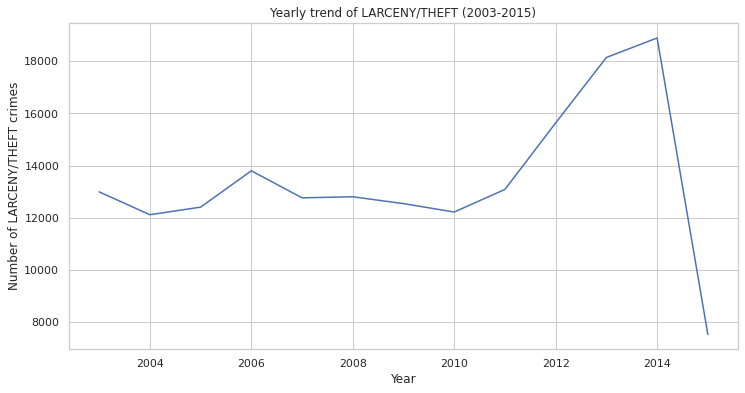

In [60]:
# 연도별로 절도범죄 사건갯수를 시각화하기

# Extract year from the 'Dates' column and create a new 'Year' column
data['Year'] = pd.to_datetime(data['Dates']).dt.year

# Filter the data for 'LARCENY/THEFT' crimes
larceny_data = data[data['Category'] == 'LARCENY/THEFT']

# Group by year and count the number of 'LARCENY/THEFT' crimes for each year
yearly_counts = larceny_data.groupby('Year').size().reset_index(name='Counts')

# Plotting the trend using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Counts', data=yearly_counts)
plt.title('Yearly trend of LARCENY/THEFT (2003-2015)')
plt.ylabel('Number of LARCENY/THEFT crimes')
plt.xlabel('Year')
plt.grid(True)
plt.show()

연도별 사건갯수 그래프를 살펴본 결과 2010~2012사이에 사건의 수가 급증하고 있는 것을 알수있다. 또 2012 ~ 2014 사이에 절도범죄가 한번더 급증한다. 2010~2014사이의 절도범죄율 추이를 살펴보자

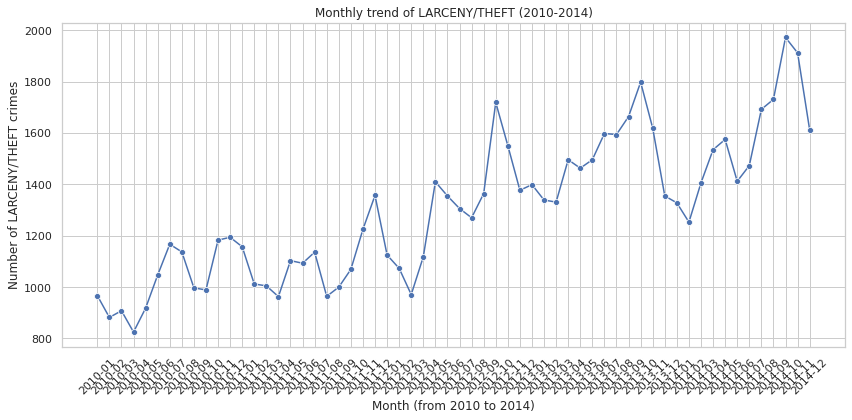

In [61]:
# 2010-2014월별 절도 그래프 시각화
# Extract year and month from 'Dates' column
data['Year'] = pd.to_datetime(data['Dates']).dt.year
data['Month'] = pd.to_datetime(data['Dates']).dt.month

# Filter the data for 'LARCENY/THEFT' crimes and the years 2011-2012
filtered_data = data[(data['Category'] == 'LARCENY/THEFT') & (data['Year'].between(2010, 2014))]

# Group by year and month, and count the number of 'LARCENY/THEFT' crimes
monthly_counts = filtered_data.groupby(['Year', 'Month']).size().reset_index(name='Counts')

# Creating a combined year-month column for better x-axis labeling
monthly_counts['Year_Month'] = monthly_counts['Year'].astype(str) + "-" + monthly_counts['Month'].astype(str).str.zfill(2)

# Plotting the monthly trend using seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year_Month', y='Counts', data=monthly_counts, marker='o')
plt.title('Monthly trend of LARCENY/THEFT (2010-2014)')
plt.ylabel('Number of LARCENY/THEFT crimes')
plt.xlabel('Month (from 2010 to 2014)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

그래프의 급증한 구간을 살펴보면 2011-09 ~ 2011-19, 2012-03 ~ 2012-04, 2012-08 ~ 2012-09에 범죄율이 확 올라갔고 2013-02 ~ 2013-09, 2014-01 ~ 2014-09년에  꾸준히 증가하는 것을 알 수 있다. 

In [62]:
# 데이터프레임에서 모든 열 간의 상관관계 행렬 계산
larceny_counts = property_data[property_data['Category'] == 'LARCENY/THEFT' ].groupby('date_year').size()
other_counts = other_data[other_data['Category'] == 'NON-CRIMINAL'].groupby('date_year').size()
personal_counts = personal_data[personal_data['Category'] == 'ASSAULT'].groupby('date_year').size()
drug_counts= drug_data[drug_data['Category'] == 'DRUG/NARCOTIC'].groupby('date_year').size()
fraud_counts = fraud_data[fraud_data['Category'] == 'FRAUD '].groupby('date_year').size()

# larceny-other
locor = pd.DataFrame({'LARCENY' : larceny_counts, 'other' : other_counts})
LaOther = locor['LARCENY'].corr(locor['other'])
# larceny-personal
lpcor = pd.DataFrame({'LARCENY' : larceny_counts, 'personal' : personal_counts})
LaPer = lpcor['LARCENY'].corr(lpcor['personal'])
# larceny-drug
ldcor = pd.DataFrame({'LARCENY' : larceny_counts, 'drug' : drug_counts})
LaDru = ldcor['LARCENY'].corr(ldcor['drug'])
# larceny-fraud
lfcor = pd.DataFrame({'LARCENY' : larceny_counts, 'fraud' : fraud_counts})
LaFra = lfcor['LARCENY'].corr(lfcor['fraud'])

print('LaOther : ', LaOther.round(3))
print('LaPer : ', LaPer.round(3))
print('LaDru : ', LaDru.round(3))
print('LaFra : ', LaFra)

LaOther :  0.949
LaPer :  0.636
LaDru :  0.044
LaFra :  nan


property와 other, personal, drug, fraud의 상관관계를 분석 해본결과 property와  other의 상관관계가 0.949로 높게 나왔고 property와 personal의 상관관계가 0.636으로 꽤 높게 나왔다. 나머지 drug와 fraud의 상관관계는 0.044, nan으로 미미함으로 상관관계가 있다고 볼수 없다. 그러면 상관관계가 있는 property와 other, personal의 관계에대해 살펴보도록 하자.

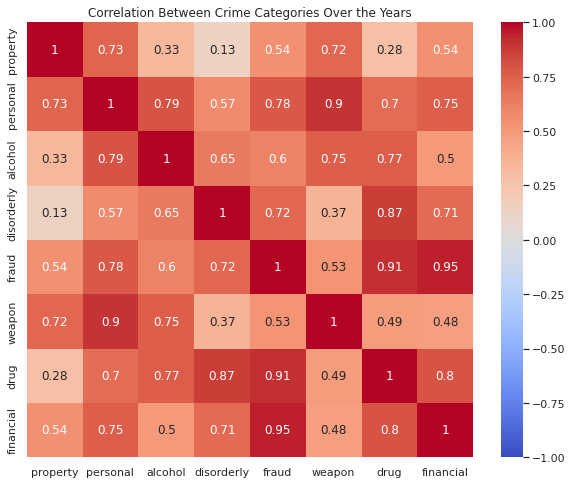

In [63]:
# 대분류 별 절도범죄와 다른 범죄들 사이의 상관관계 시각화

# Sample data
data['Year'] = pd.to_datetime(data['Dates']).dt.year

# Define the crime categories
categories = {
    "property": ['LARCENY/THEFT', 'VEHICLE THEFT', 'BURGLARY', 'STOLEN PROPERTY', 'ARSON', 'EXTORTION'],
    "personal": ['ASSAULT','KIDNAPPING','SEX OFFENSES FORCIBLE','ROBBERY','HOMICIDE','FAMILY OFFENSES','TRESPASS'],
    "alcohol": ['DRUNKENNESS','DRIVING UNDER THE INFLUENCE','LIQUOR LAWS'],
    "disorderly": ['DISORDERLY CONDUCT','LOITERING'],
    "fraud": ['FORGERY/COUNTERFEITING','FRAUD'],
    "weapon": ['WEAPON LAWS'],
    "drug": ['DRUG/NARCOTIC'],
    "financial": ['BAD CHECKS','EMBEZZLEMENT','BRIBERY']
}

# Calculate counts for each category by year
category_counts = {category: data[data['Category'].isin(crime_list)].groupby('Year').size() for category, crime_list in categories.items()}

# Convert the dictionary to a DataFrame
df_counts = pd.DataFrame(category_counts)

# Calculate the correlation matrix
correlation_matrix = df_counts.corr()

# Visualizing the correlation using seaborn's heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Between Crime Categories Over the Years')
plt.show()


여기서 property에 국한하지 않고, 상관계수가 높은 다른 대분류를 찾아보면 fraud- financial, fraud-drug 등 몇 가지 연관성이 있는 카테고리들이 있다.

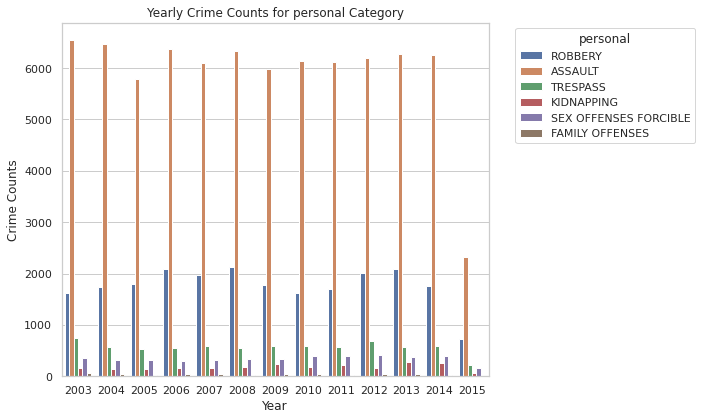

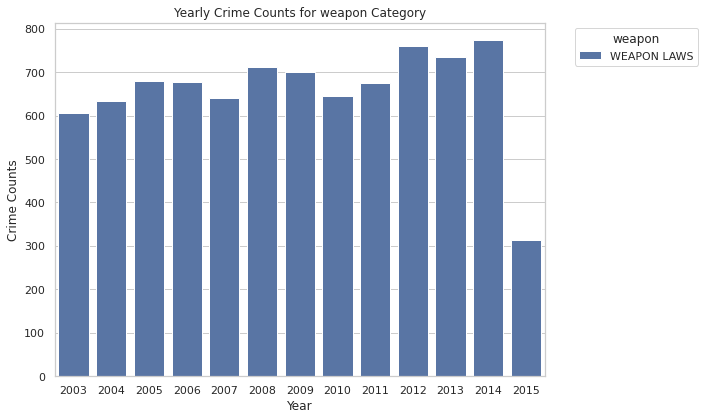

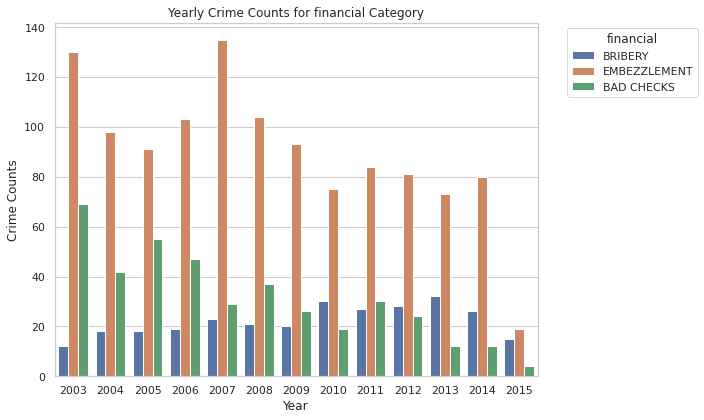

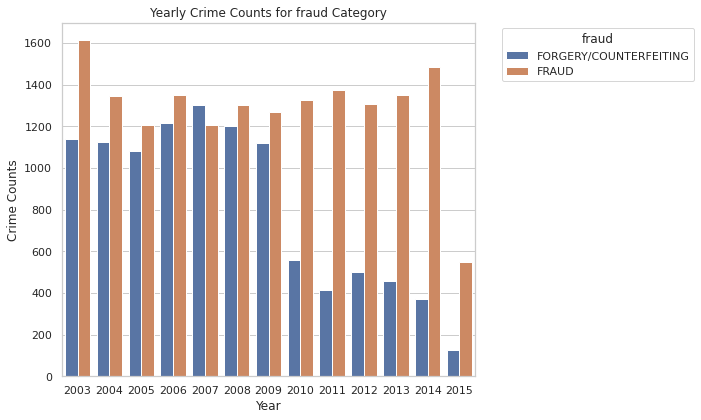

In [64]:
# top 3 대주제별 세부 범죄 발생률 그래프

# Extract year from the 'Dates' column
data['Year'] = pd.to_datetime(data['Dates']).dt.year

# Define categories
categories = {
    "personal": ['ASSAULT','KIDNAPPING','SEX OFFENSES FORCIBLE','ROBBERY','HOMICIDE','FAMILY OFFENSES','TRESPASS'],
    "weapon": ['WEAPON LAWS'],
    "financial": ['BAD CHECKS','EMBEZZLEMENT','BRIBERY'],
    "fraud": ['FORGERY/COUNTERFEITING','FRAUD']
}

for main_category, sub_categories in categories.items():
    plt.figure(figsize=(10, 6))
    
    # Create a DataFrame for the specific main category
    df_sub = data[data['Category'].isin(sub_categories)]
    
    # Use seaborn to create the barplot
    sns.countplot(data=df_sub, x='Year', hue='Category')
    
    plt.title(f'Yearly Crime Counts for {main_category} Category')
    plt.ylabel('Crime Counts')
    plt.xlabel('Year')
    plt.legend(title=main_category, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

financial, fraud는 property와 상관관계가 0.54로 낮기 때문에 제외하고 personal, weapon을 사용하여 property와의 관계를 분석해보자. property와와 연관이 깉은 범죄 카테고리를 지역별로 시각화하여 범죄 발생지역이 상관이 있는지 살펴보자.
### property와 연관이 깊은 범죄 대분류 카테고리

1. property에서 가장 발생율이 높은 범죄 카테고리 - LARCENY,THEFT

2. personal에서 가장 발생율이 높은 범죄 카테고리 - ASSAULT

3. weapon에서 가장 발생율이 높은 범죄 카테고리(단일항목) - WEAPON LAWS

scatterplot을 이용한 세 가지 범죄항목에 대한 분포를 그래프로 시각화해보자. 

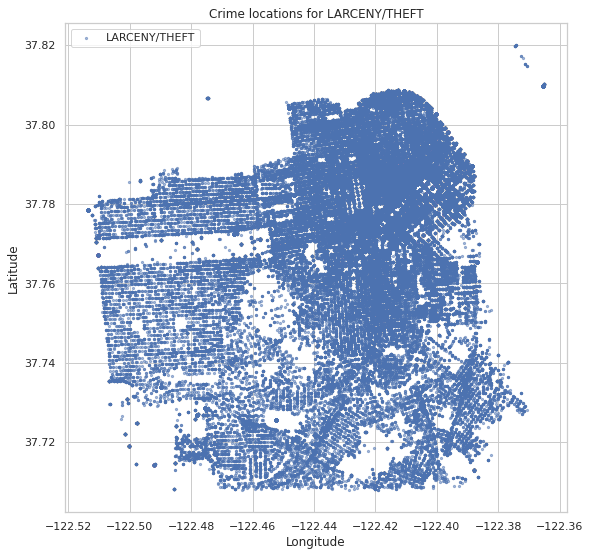

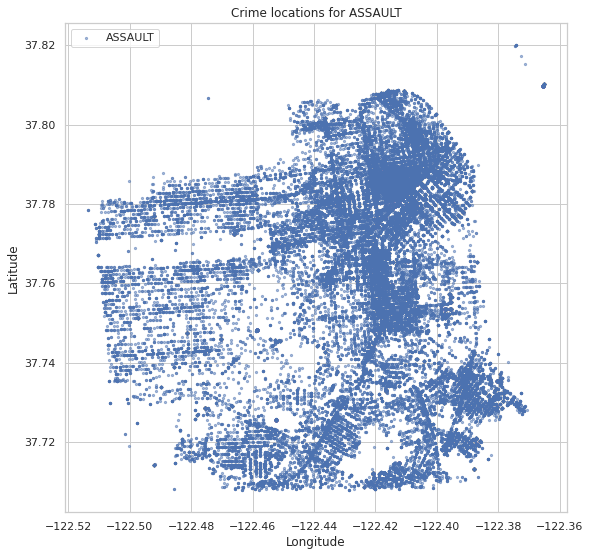

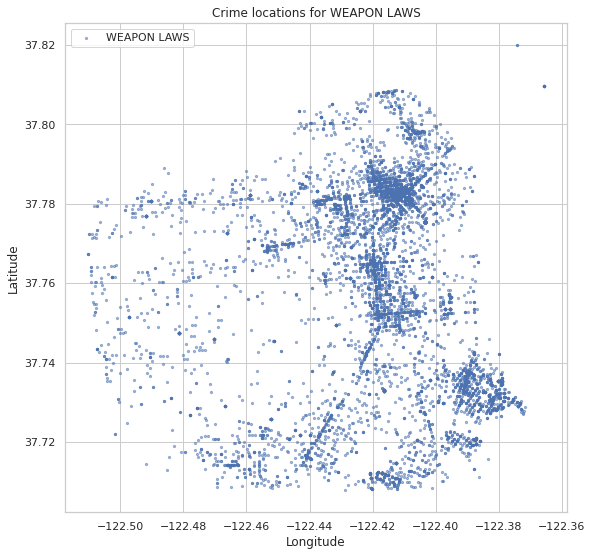

In [65]:
categories = ['LARCENY/THEFT', 'ASSAULT', 'WEAPON LAWS']

for category in categories:
    category_data = data[data['Category'] == category]
    
    # For 'LARCENY/THEFT' and 'ASSAULT', filter by the provided latitude and longitude ranges
    if category in ['LARCENY/THEFT', 'ASSAULT']:
        category_data = category_data[(category_data['Y'] <= 50) & (category_data['X'] <= -122)]
    
    # Plot
    plt.figure(figsize=(9, 9))
    
    # Plot specific category
    plt.scatter(category_data['X'], category_data['Y'], alpha=0.5, label=category, s=5)
    
    # Settings and show
    plt.title(f"Crime locations for {category}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()

위 그래프를 보면 특정구역에서  personal, weapon, property의 범죄가 밀집되어 발생하는 것을 알 수 있다. 히트맵을 이용해 범죄 밀집구역을 좀 더 명료하게 나타내보자

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


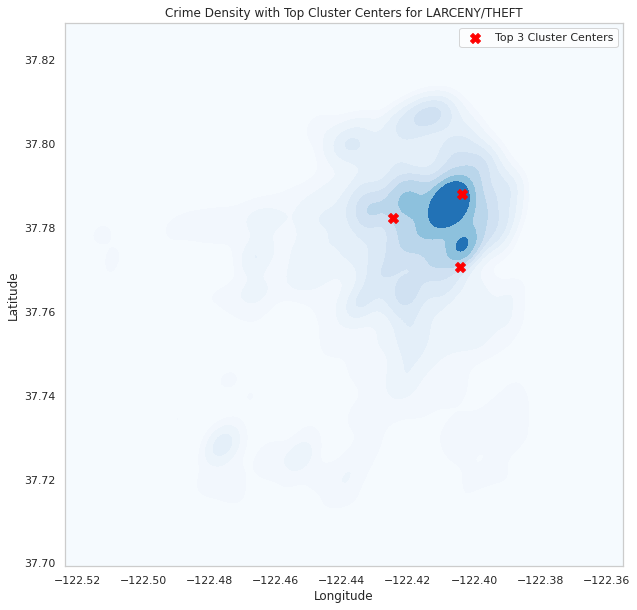

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


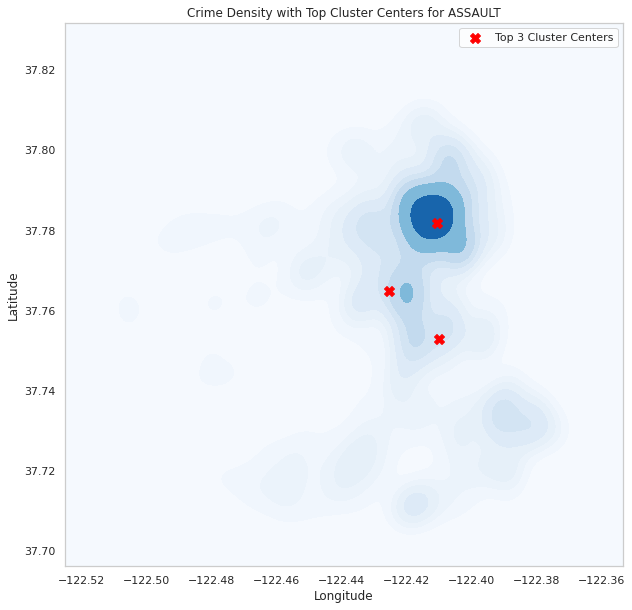

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


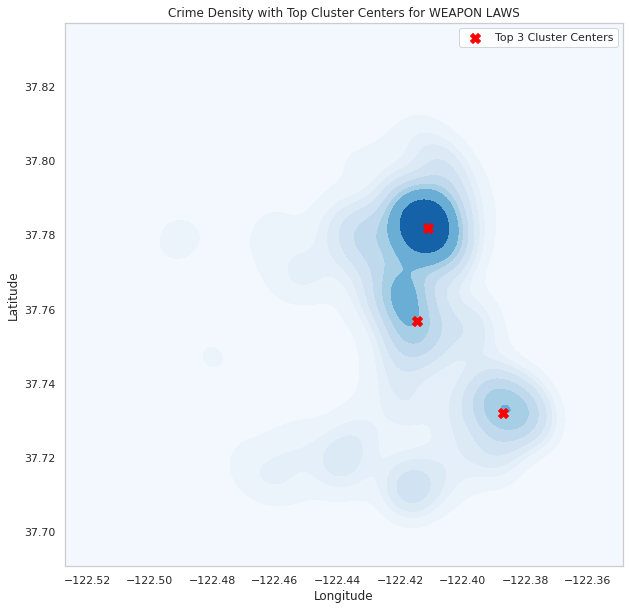

In [66]:
from sklearn.cluster import KMeans
import numpy as np

categories = ['LARCENY/THEFT', 'ASSAULT', 'WEAPON LAWS']

for category in categories:
    category_data = data[data['Category'] == category]
    
    # For 'LARCENY/THEFT' and 'ASSAULT', filter by the provided latitude and longitude ranges
    if category in ['LARCENY/THEFT', 'ASSAULT']:
        category_data = category_data[(category_data['Y'] <= 50) & (category_data['X'] <= -122)]
    
    # Use KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=0).fit(category_data[['X', 'Y']])
    
    # Count the points in each cluster
    cluster_sizes = [np.sum(kmeans.labels_ == i) for i in range(10)]
    
    # Get indices of three largest clusters
    top_clusters = np.argsort(cluster_sizes)[-3:]
    
    # Get the centers of the top clusters
    top_cluster_centers = kmeans.cluster_centers_[top_clusters]
    
    # Plot
    plt.figure(figsize=(10, 10))
    
    # KDE plot for specific category
    sns.kdeplot(x=category_data['X'], y=category_data['Y'], cmap="Blues", shade=True, shade_lowest=True)
    
    # Plot the centers of the top clusters
    plt.scatter(top_cluster_centers[:, 0], top_cluster_centers[:, 1], c='red', s=100, marker='X', label="Top 3 Cluster Centers")
    
    # Settings and show
    plt.title(f"Crime Density with Top Cluster Centers for {category}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()

Top 1 Cluster Center for LARCENY/THEFT - Longitude: -122.40437, Latitude: 37.77055
Top 2 Cluster Center for LARCENY/THEFT - Longitude: -122.42443, Latitude: 37.78209
Top 3 Cluster Center for LARCENY/THEFT - Longitude: -122.40376, Latitude: 37.78800


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


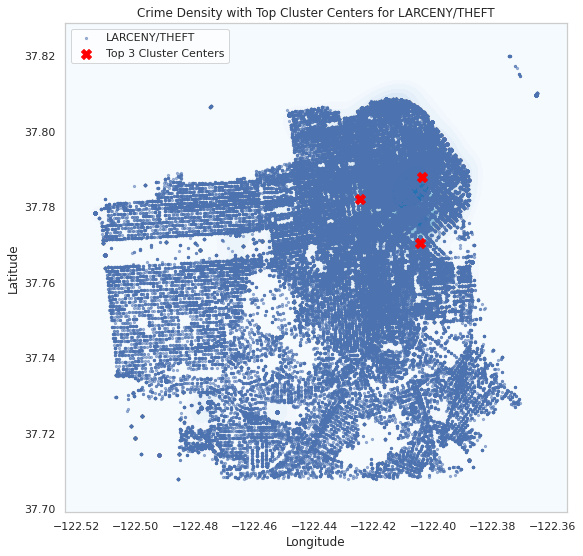

Top 1 Cluster Center for ASSAULT - Longitude: -122.41017, Latitude: 37.75282
Top 2 Cluster Center for ASSAULT - Longitude: -122.42533, Latitude: 37.76470
Top 3 Cluster Center for ASSAULT - Longitude: -122.41058, Latitude: 37.78190


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


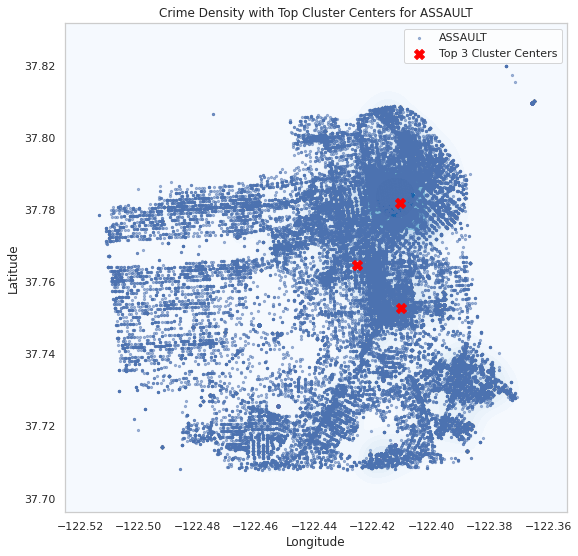

Top 1 Cluster Center for WEAPON LAWS - Longitude: -122.38713, Latitude: 37.73204
Top 2 Cluster Center for WEAPON LAWS - Longitude: -122.41467, Latitude: 37.75686
Top 3 Cluster Center for WEAPON LAWS - Longitude: -122.41120, Latitude: 37.78184


/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1718: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.
  warnings.warn(msg, UserWarning)


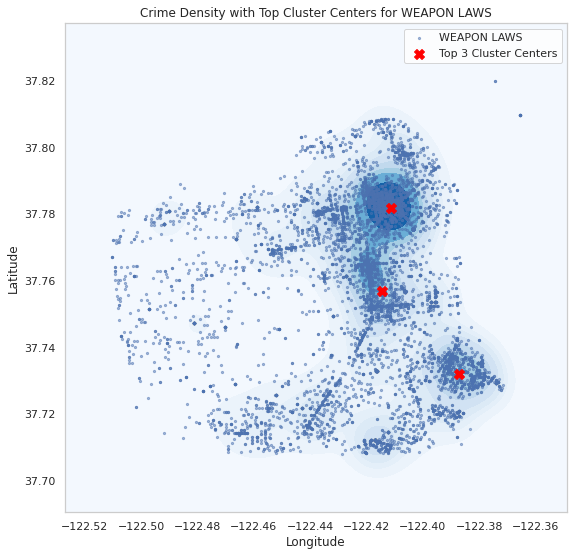

In [67]:
#scatterplot 범죄별 밀집지역 top3 클러스터링과 좌표

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

categories = ['LARCENY/THEFT', 'ASSAULT', 'WEAPON LAWS']

for category in categories:
    category_data = data[data['Category'] == category]
    
    # For 'LARCENY/THEFT' and 'ASSAULT', filter by the provided latitude and longitude ranges
    if category in ['LARCENY/THEFT', 'ASSAULT']:
        category_data = category_data[(category_data['Y'] <= 50) & (category_data['X'] <= -122)]
    
    # Use KMeans clustering
    kmeans = KMeans(n_clusters=10, random_state=0).fit(category_data[['X', 'Y']])
    
    # Count the points in each cluster
    cluster_sizes = [np.sum(kmeans.labels_ == i) for i in range(10)]
    
    # Get indices of three largest clusters
    top_clusters = np.argsort(cluster_sizes)[-3:]
    
    # Get the centers of the top clusters
    top_cluster_centers = kmeans.cluster_centers_[top_clusters]
    
    # Print the centers of the top clusters
    for idx, center in enumerate(top_cluster_centers, 1):
        print(f"Top {idx} Cluster Center for {category} - Longitude: {center[0]:.5f}, Latitude: {center[1]:.5f}")
    
    # Plot
    plt.figure(figsize=(9, 9))
    
    # KDE plot for specific category
    sns.kdeplot(x=category_data['X'], y=category_data['Y'], cmap="Blues", shade=True, shade_lowest=True)
    
    # Scatter plot for specific category
    plt.scatter(category_data['X'], category_data['Y'], alpha=0.5, label=category, s=5)
    
    # Plot the centers of the top clusters
    plt.scatter(top_cluster_centers[:, 0], top_cluster_centers[:, 1], c='red', s=100, marker='X', label="Top 3 Cluster Centers")
    
    # Settings and show
    plt.title(f"Crime Density with Top Cluster Centers for {category}")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend()
    plt.grid(True)
    plt.show()


각각의 범죄류 중 가장 높은 밀집도를 보인 탑 3 지역을 지도에 찍어보고, 해당 지역의 인프라/ 수입등 전반적인 환경을 주변 도시와 같이 비교해 보았다.

1. 절도범죄 탑 3 위치 확인 결과 > 주변에 공원이 있거나 관광지인 곳. 식당가 근처 등 여행객의 방문이 잦은 곳. 
2. 폭력범죄 탑 3 위치 확인 결과 > 우범지역을 포함하는 곳도 있음(텐덜로앵). 전체적인 지역 양상은 절도범죄와 비슷함.
3. 총기범죄 탑 3 위치 확인 결과 > 위의 두 범죄 양상과 비교해 확연히 우범지역 내에 위치해 있음. (텐덜로앵, 헌터스포인트) 

시계열 데이터를 분석하여 범죄가 많이 일어나는 시간대, 요일, 월을 비교하여 분석해보자

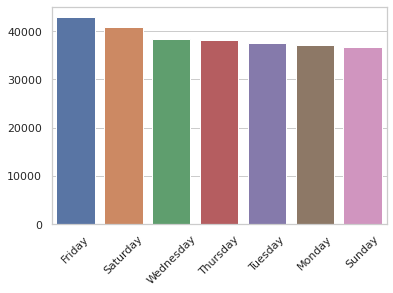

In [68]:
# 요일별 절도범되 발생수 시각화 
property_day = property_data['DayOfWeek'].value_counts()
sns.barplot(x = property_day.index, y = property_day.values)
plt.xticks(rotation = 45)
plt.show()

절도범죄가 제일 많이 일어나는 요일은 금요일, 토요일에 제일많이 일어나는것을 알 수 있다.

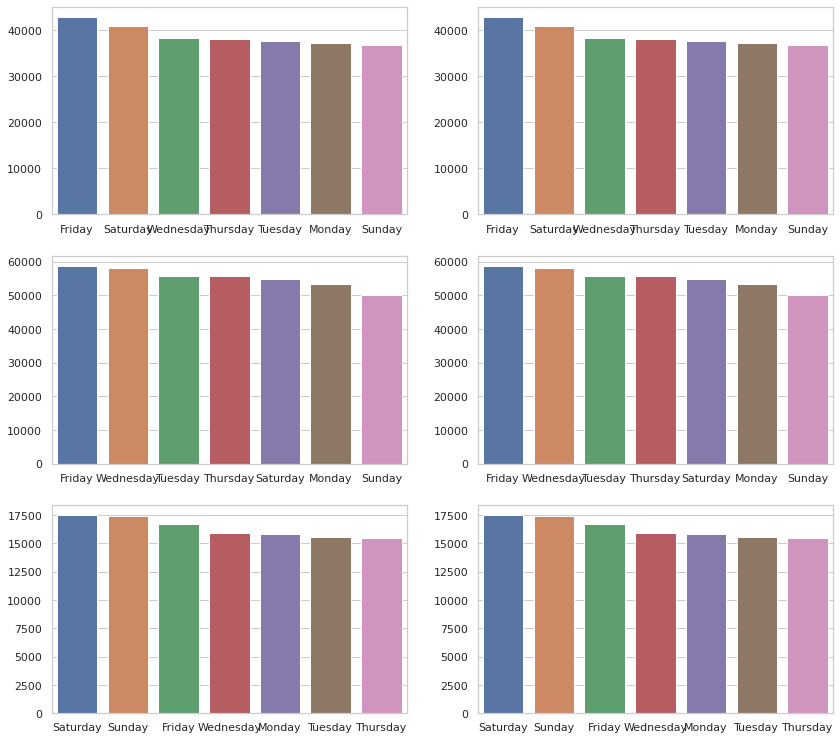

In [69]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(14, 13))

# property_cate
crimes = [property_data, other_data, personal_data, drug_data, fraud_data]

for i in range(3): 
    for j in range(2) :
        d = crimes[i]['DayOfWeek'].value_counts()
        sns.barplot(x = d.index, y = d.values , ax=axes[i, j])

plt.show()


위의 그래프에서 알수 있듯이 모든 범죄가 금요일과 토요일에 많이 발생하는 것을 알 수 있다. 

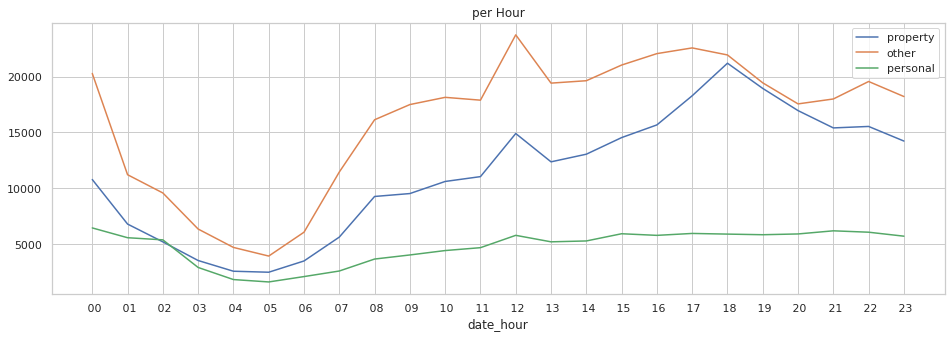

In [70]:
# 하루 시간대별 범죄 발생 확인
# property_data, other_data,personal_data

hour_df = property_data.groupby('date_hour').count().iloc[:, 0]
hour_df2 = other_data.groupby('date_hour').count().iloc[:, 0]
hour_df3 = personal_data.groupby('date_hour').count().iloc[:, 0]

fig, ax = plt.subplots(figsize = (16, 5))
ax = sns.lineplot(x = hour_df.index, y = hour_df.values, label = 'property')
sns.lineplot(x = hour_df2.index, y = hour_df2.values, label = 'other' )
sns.lineplot(x = hour_df3.index, y = hour_df3.values, label = 'personal')
plt.legend()
plt.title('per Hour')
plt.show()

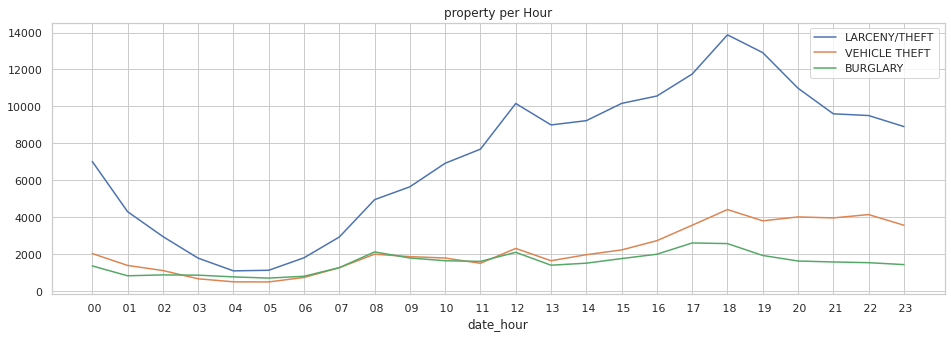

In [71]:
# 각 범주별 카테고리를 세분화하며 각 범죄의 
# property_data['Category'].value_counts() 
LA_data = property_data[property_data['Category'] == 'LARCENY/THEFT']
VE_data = property_data[property_data['Category'] == 'VEHICLE THEFT']
BU_data = property_data[property_data['Category'] == 'BURGLARY']

# 시각화하기 
# 하루 시간대별 범죄 발생 확인

p_df = LA_data.groupby('date_hour').count().iloc[:, 0]
p_df2 = VE_data.groupby('date_hour').count().iloc[:, 0]
p_df3 = BU_data.groupby('date_hour').count().iloc[:, 0]


fig, ax = plt.subplots(figsize = (16, 5))
ax = sns.lineplot(x = p_df.index, y = p_df.values, label = 'LARCENY/THEFT')
sns.lineplot(x = p_df2.index, y = p_df2.values, label = 'VEHICLE THEFT' )
sns.lineplot(x = p_df3.index, y = p_df3.values, label = 'BURGLARY')

plt.legend()
plt.title('property per Hour')
plt.show()


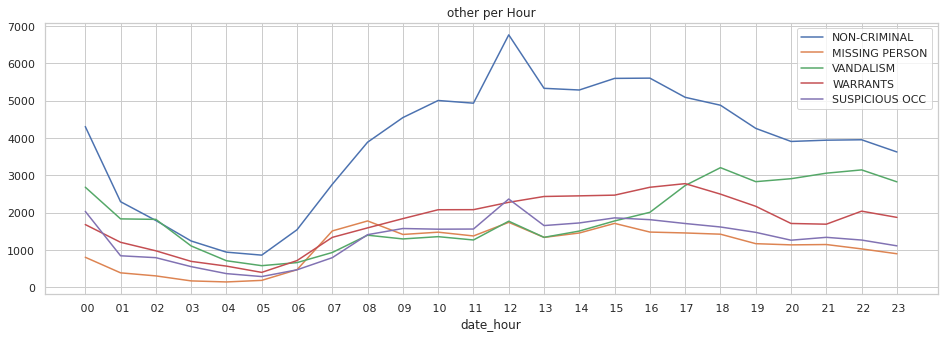

In [72]:
# other_data['Category'].value_counts()
NON_data = other_data[other_data['Category'] == 'NON-CRIMINAL']
VAN_data = other_data[other_data['Category'] == 'VANDALISM']
WAR_data = other_data[other_data['Category'] == 'WARRANTS']
SUS_data = other_data[other_data['Category'] == 'SUSPICIOUS OCC']
MIS_data = other_data[other_data['Category'] == 'MISSING PERSON']

o_df = NON_data.groupby('date_hour').count().iloc[:, 0]
o_df2 = VAN_data.groupby('date_hour').count().iloc[:, 0]
o_df3 = WAR_data.groupby('date_hour').count().iloc[:, 0]
o_df4 = SUS_data.groupby('date_hour').count().iloc[:, 0]
o_df5 = MIS_data.groupby('date_hour').count().iloc[:, 0]

fig, ax = plt.subplots(figsize = (16, 5))
sns.lineplot(x = o_df.index, y = o_df.values, label = 'NON-CRIMINAL')
sns.lineplot(x = o_df5.index, y = o_df5.values, label = 'MISSING PERSON')
sns.lineplot(x = o_df2.index, y = o_df2.values, label = 'VANDALISM' )
sns.lineplot(x = o_df3.index, y = o_df3.values, label = 'WARRANTS')
sns.lineplot(x = o_df4.index, y = o_df4.values, label = 'SUSPICIOUS OCC')

plt.legend()
plt.title('other per Hour')
plt.show()

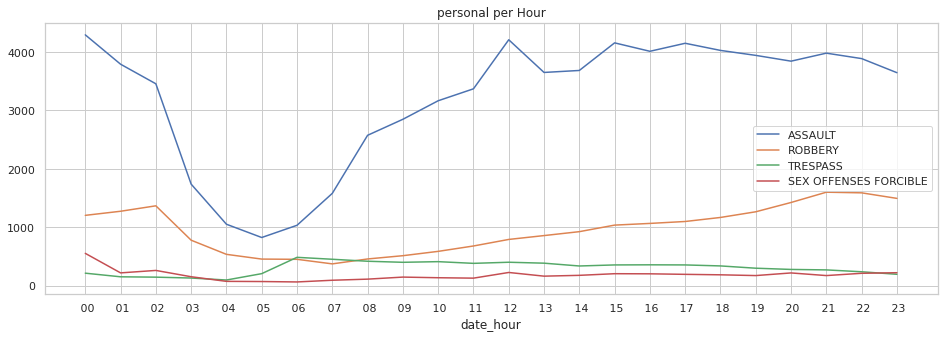

In [73]:
# personal_data['Category'].value_counts()


AS_data = personal_data[personal_data['Category'] == 'ASSAULT']
ROB_data = personal_data[personal_data['Category'] == 'ROBBERY']
TRE_data = personal_data[personal_data['Category'] == 'TRESPASS']
SEX_data = personal_data[personal_data['Category'] == 'SEX OFFENSES FORCIBLE']


e_df = AS_data.groupby('date_hour').count().iloc[:, 0]
e_df2 = ROB_data.groupby('date_hour').count().iloc[:, 0]
e_df3 = TRE_data.groupby('date_hour').count().iloc[:, 0]
e_df4 = SEX_data.groupby('date_hour').count().iloc[:, 0]

fig, ax = plt.subplots(figsize = (16, 5))
sns.lineplot(x = e_df.index, y = e_df.values, label = 'ASSAULT')
sns.lineplot(x = e_df2.index, y = e_df2.values, label = 'ROBBERY' )
sns.lineplot(x = e_df3.index, y = e_df3.values, label = 'TRESPASS')
sns.lineplot(x = e_df4.index, y = e_df4.values, label = 'SEX OFFENSES FORCIBLE' )

plt.legend()
plt.title('personal per Hour')
plt.show()


위의 그래프를 보아 personal의 assault와 property의 LARCENY/THEFT가 상관관계가 있어 보인다. 같은 시간대에 범죄율이 같이 올라가는 것을 알 수 있다.

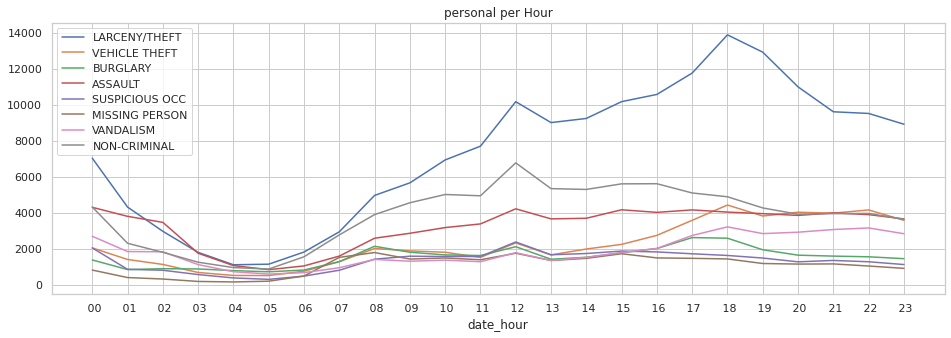

In [74]:

fig, ax = plt.subplots(figsize = (16, 5))

# property
sns.lineplot(x = p_df.index, y = p_df.values, label = 'LARCENY/THEFT')
sns.lineplot(x = p_df2.index, y = p_df2.values, label = 'VEHICLE THEFT' )
sns.lineplot(x = p_df3.index, y = p_df3.values, label = 'BURGLARY')

# personal
sns.lineplot(x = e_df.index, y = e_df.values, label = 'ASSAULT')

# other
sns.lineplot(x = o_df4.index, y = o_df4.values, label = 'SUSPICIOUS OCC')
sns.lineplot(x = o_df5.index, y = o_df5.values, label = 'MISSING PERSON')
sns.lineplot(x = o_df2.index, y = o_df2.values, label = 'VANDALISM' )
sns.lineplot(x = o_df.index, y = o_df.values, label = 'NON-CRIMINAL')

plt.legend()
plt.title('personal per Hour')
plt.show()

비슷한 추이의 범죄유형들을 모아보니 확실히 12시 점심시간과 6-7시 저녁시간대에 범죄가 증가하는 것을 알수 있다. 

각각의 범죄류 중 가장 높은 밀집도를 보인 탑 3 지역을 지도에 찍어보고, 해당 지역의 인프라/ 수입등 전반적인 환경을 주변 도시와 같이 비교해    보았을 때 아래와 같았다. 

1. 절도범죄 탑 3 위치 확인 결과 > 주변에 공원이 있거나 관광지인 곳. 식당가 근처 등 여행객의 방문이 잦은 곳. 
2. 폭력범죄 탑 3 위치 확인 결과 > 우범지역을 포함하는 곳도 있음(텐덜로앵). 전체적인 지역 양상은 절도범죄와 비슷함.
3. 총기범죄 탑 3 위치 확인 결과 > 위의 두 범죄 양상과 비교해 확연히 우범지역 내에 위치해 있음. (텐덜로앵, 헌터스포인트) 

결론 : 절도사건을 기준으로 상관관계가 가장 높은 두 사건인 폭력범죄와 총기범죄를 비교했을 때, 세 범죄 유형 모두 비슷한 밀집도를 보였으나, top3 클러스터링 좌표를 확인해보면 두 가지 양상으로 나뉘었음.  절도범죄와 폭력범죄는 관광객 등 유동인구가 많은 공원, 박물관, 식당에서 빈번하게 일어났음을 알 수 있다. 또한 12시와 6시에 범죄수가 증가하는 것을 보아 이동객들을 대상으로한 여행객의 물건을 훔치거나 여행지/ 관광지에서 거주민과 여행객 사이 혹은 거주민 사이에 일어나는 싸움과 범죄가 빈번하게 일어난다고 추론할 수 있음. 이는 샌프란시스코의 고질적인 문제 중 하나인 홈리스 문제와도 연관이 있다고 생각됨. 
 또한 클러스터링 된 지역 자체가 우범 지역과 지리적으로 가깝기 때문에, 총기사고의 위협에서 안전하다고 판단되지 않음. 총기범죄는 샌프란시스코 내에서도 전통적인 우범지역에 다수 포진되어 있는 것을 볼 때, 해당 지역의 치안이 상당히 좋지 않고 이를 방지하기 위한 행정적 지원이 충분치 않다고 판단할 수 있음. 상대적으로 경범죄로 취급되는 절도, 폭력 사건과 달리 총기사건은 중범죄로 목숨까지 위협할 수 있으므로 이에 대한 경찰력 증대 등 행정적 조치가 필요함. 또한, 근본적인 원인 제거를 위해 슬럼가 개선을 위한 주거정책, 일자리 정책등 사회제도적 방안의 보안이 필요함.